## Paper information
Song, Y., & Ermon, S. (2020). Improved techniques for training score-based generative models.  
Advances in neural information processing systems, 33, 12438-12448.

## Code authors
Merve Tapli (mtapli@ceng.metu.edu.tr)
Sezai Artun Ozyegin (artunozyegin@gmail.com)

## Refered papers

[1] Improved Techniques for Training Score-Based Generative Models. NeurIPS 2020 https://arxiv.org/pdf/2006.09011.pdf

[2] Generative modeling by estimating gradients of the data distribution. NeurIPS 2019 https://arxiv.org/pdf/1907.05600.pdf

[3] RefineNet: Multi-Path Refinement Networks for High-Resolution Semantic Segmentation. CVPR 2017 https://arxiv.org/pdf/1611.06612.pdf

[4] GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium. NeurIPS 2017 https://arxiv.org/pdf/1706.08500.pdf

[5] Estimation of Non-Normalized Statistical Models by Score Matching. JMLR 6.4 2005 https://www.jmlr.org/papers/volume6/hyvarinen05a/hyvarinen05a.pdf

[6] Adversarial score matching and improved sampling for image generation. ICLR 2021 https://arxiv.org/pdf/2009.05475.pdf

[7] pytorch-fid: FID Score for PyTorch. 2020. https://github.com/mseitzer/pytorch-fid

## Workflow
* Paper Summary: Introduction, Background
* Imports
* Toy dataset argument setting and training
* Toy dataset vector field visualization
* Setting the device and arguments/hyperparameters
* Paper Summary: Technique 1 explanation and code for calculating $\sigma_1$
* Paper Summary: Technique 2 explanation and codes for calculating $\gamma$ and $L$
* Paper Summary: Technique 3 explanation
* Paper Summary: Technique 4 explanation and code for calculating $\epsilon$ given $T$
* Paper Summary: Technique 5 explanation
* Training and saving checkpoints
    * If a pretrained model does not exist, start training procedure.
        * Obtain the dataloader for train set
        * Obtain the NCSNv2 model
        * Obtain the optimizer
        * Start training procedure to estimate the unconditional score functions
        * Save the model at every 5000 iteration
* Loading the pretrained model, sampling and FID calculation
    * Obtain the NCSNv2 model
    * Obtain the dataloader for test set
    * Calculate the noise scales using geometric progression
    * For each checkpoint
        * If samples from this checkpoint does not exist load the model and sample 1000 images from it using Annealed Langevin Dynamics
        * Calculate FID between real test images and the sampled images
        * Keep track of the checkpoint that gives the best FID
* Quantitative results:
    * Discussion on the quantitative goals
    * Sampling 50000 images using the best checkpoint
    * Calculating FID using both test and train images
    * Sanity check of the FID calculation with a readily available FID module
* Qualitative results:
    * Discussian on the qualitative goals
    * Visualization of samples from the model
* Challenges encountered

## Paper Summary

### Introduction

The score-based generative models proposed by Song and Ermon [2] has many different hyperparameters from the training to sampling and their values are related with each other and very important to obtain good results. Song and Ermon [1], grounds this selection of hyperparameters on theoretical analysis which is the main focus of the paper we try to reproduce. Therefore, we first give a small background information on score-based generative modeling. Then, we discuss the 5 techniques proposed to improve their performance.

### Background
In score-based generative modeling, we try to estimate a vector field on data space (e.g. image space $\mathbb{R}^{C\times H \times W}$) which basically points towards to higher density regions of the data distribution $p_{data}$. More formally, our model takes an input $\mathbf{x} \sim p_{data}(\mathbf{x})$ and tries to estimate $\nabla_{\mathbf{x}} \log p_{data}(\mathbf{x})$, which is called the score function. Later, after the training, we will be able to sample new data from the model by using this estimated vector field.

A way to train a model to estimate $\nabla_{\mathbf{x}} \log p_{data}(\mathbf{x})$ without really having to estimate the density functions with, for example, non-parametric methods has been shown to be possible by Hyvarinen and Dayan [5]. However, Song and Ermon [2] claims that the score estimations won't be accurate in low data density regions or if the data distribution is supported on a low dimensional manifold (which is the case for image domain); therefore, they propose to **corrupt the data with Gaussian noise with different intensities**.

Let $\sigma_1 > \sigma_2 > \dots > \sigma_L$ be our noise scales. Given a data point $\mathbf{x}$, for a specific noise scale, $\sigma_i$, we are going to sample the corrupted image from the Gaussian distribution centered at the original image, which can be written as $\mathbf{\tilde{x}} \sim \mathcal{N}(\mathbf{\tilde{x}}; \mathbf{x}, \sigma_i^2 \mathbf{I})$. Let $\mathbf{s_{\theta}}(\mathbf{x}, \sigma_i)$ be our score network conditioned on noise scale (which will be slightly modified in `Technique 3` section). The score network is trained by the following loss:

<center>
$\dfrac{1}{2L} \sum_{1}^{L} \mathbb{E}_{p_{data}(\mathbf{x})}\mathbb{E}_{p_{\sigma_i}(\mathbf{\tilde{x}}| \mathbf{x})}\left[ \left| \left| \sigma_i \mathbf{s_{\theta}}(\mathbf{\tilde{x}}, \sigma_i) + \dfrac{\mathbf{\tilde{x}} - \mathbf{x}}{\sigma_i} \right| \right|_{2}^{2} \right]$.
</center>

After training, Song and Ermon [2] expect the model to satisfy $\mathbf{s_{\theta^{*}}}(\mathbf{x}, \sigma_i) = \nabla_{\mathbf{x}} \log p_{\sigma_i}(\mathbf{x})$ almost everywhere. If we had the score function $\nabla_{\mathbf{x}} \log p(\mathbf{x})$ without different noise scales, Langevin dynamics would iterate the following:

<center>
$\mathbf{x}_t \leftarrow \mathbf{x}_{t-1} + \alpha \nabla_{\mathbf{x}} \log p(\mathbf{x}_{t-1}) + \sqrt{2\alpha} \mathbf{z}_{t}$, $1 \leq t \leq T$,
</center>

where $\alpha >0$ is the step size, $T$ is the number of steps, $\mathbf{z}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$. The inital $\mathbf{x}_{0}$ can be sampled from some prior distribution. Song and Ermon[1] states that when $\alpha$ is sufficiently small and $T$ is sufficiently large, the distribution of $\mathbf{x}_{T}$ will be close to $p(\mathbf{x})$ under some regularity conditions.


To incorporate different levels of noise scales into the sampling procedure, Song and Ermon [2] use Annealed Langeving Dynamics which samples from $p_{\sigma_1}(\mathbf{x})$, $p_{\sigma_2}(\mathbf{x})$, $\dots$, $p_{\sigma_L}(\mathbf{x})$ sequentially using Langevin Dynamics. For different noise scales, different steps sizes are calculated. For $i^{th}$ noise scale, the step size is $\alpha_i = \epsilon \frac{\sigma_i^2}{\sigma_L^2}$ where $\epsilon$ is a hyperparameter. How to set $\epsilon$ is discussed in `Technique 4` section. The overall algorithm can be seen below, which is taken from Song and Ermon [1].

<img src="images/annealed_langevin_dynamics.jpg" alt="annealed_langevin_dynamics" width="350"/>

Notice the optional additional step at the end of the algorithm where one final update on $\mathbf{x}_T$ is done **without** adding noise $\mathbf{z}_T$. This "denoising" part was not applied by Song and Ermon [2] which is introduced by Jolicoeur-Martineau et al. [6] and shown to improve the FID scores. We apply this additional step in our implementation.


In [1]:
import os
import torch
import torchvision
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
from models.models import get_model
from scipy.stats import norm
from datasets.datasets import get_dataloader
from collections import namedtuple
from utils import *
from train import train
from test import test

%load_ext autoreload
%autoreload 2

In [2]:
# Toy dataset example

Args = namedtuple('Args', ['cuda',
                           'dataset',
                           'model',
                           'batch_size',
                           'epochs',
                           'lr',
                           'L',
                           'sigma1',
                           'eps',
                           'T',
                           'reduction'])
args = Args(
    cuda = False,
    dataset = 'ToyDataset',
    model = 'ToyModel',
    batch_size = 32,
    epochs = 2000,
    lr = 1e-4, # learning rate
    L = 232, # the number of noise scales
    sigma1 = 29, # the largest noise scale
    eps = 6.2e-6, # the scaling constant used in step-size calculation
    T = 5, # the number of iterations done at every noise scale in Annealed Langevin Dynamics
    reduction = 'mean'
)

device = torch.device('cuda' if args.cuda else 'cpu')
name = get_name(args)
save_folder = os.path.join('model_saves', name)

train_loader = get_dataloader(args.dataset, True, args.batch_size)
model = get_model(args.model).to(device)
optimizer = optim.Adam(model.parameters(), lr=args.lr)
train(model, train_loader, optimizer, device, args)



100%|███████████████████████████████████████████| 15/15 [00:03<00:00,  4.78it/s]


Epoch: 0, loss: 1.4553698301315308


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.97it/s]


Epoch: 1, loss: 1.4281721671422323


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.70it/s]


Epoch: 2, loss: 1.3666558464368184


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.92it/s]


Epoch: 3, loss: 1.2408531427383422


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.20it/s]


Epoch: 4, loss: 1.1673943042755126


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.55it/s]


Epoch: 5, loss: 1.12168155113856


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.52it/s]


Epoch: 6, loss: 1.0994413177172342


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.03it/s]


Epoch: 7, loss: 0.9781160076459249


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 49.45it/s]


Epoch: 8, loss: 1.1037261088689168


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.64it/s]


Epoch: 9, loss: 0.8973958015441894


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.81it/s]


Epoch: 10, loss: 0.9589856386184692


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 50.80it/s]


Epoch: 11, loss: 0.9489753842353821


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.48it/s]


Epoch: 12, loss: 0.978599504629771


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.00it/s]


Epoch: 13, loss: 0.9253339250882466


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.03it/s]


Epoch: 14, loss: 0.9040311574935913


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 52.88it/s]


Epoch: 15, loss: 0.8345297992229461


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.13it/s]


Epoch: 16, loss: 0.8952279011408488


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.27it/s]


Epoch: 17, loss: 0.8933140794436137


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.13it/s]


Epoch: 18, loss: 0.8666735490163168


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.52it/s]


Epoch: 19, loss: 0.8218346039454142


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.48it/s]


Epoch: 20, loss: 0.8095553676287334


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.35it/s]


Epoch: 21, loss: 0.8097422599792481


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 51.53it/s]


Epoch: 22, loss: 0.8253810803095499


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.69it/s]


Epoch: 23, loss: 0.8106622258822124


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.81it/s]


Epoch: 24, loss: 0.8139799276987711


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.39it/s]


Epoch: 25, loss: 0.9026660601298014


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.88it/s]


Epoch: 26, loss: 0.836086118221283


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.32it/s]


Epoch: 27, loss: 0.7667088111241659


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.92it/s]


Epoch: 28, loss: 0.7931984464327494


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 49.37it/s]


Epoch: 29, loss: 0.8049286882082621


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.51it/s]


Epoch: 30, loss: 0.7955682913462321


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.84it/s]


Epoch: 31, loss: 0.8604312698046367


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 48.90it/s]


Epoch: 32, loss: 0.7887460271517436


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.86it/s]


Epoch: 33, loss: 0.7678070068359375


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.53it/s]


Epoch: 34, loss: 0.8297433853149414


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.23it/s]


Epoch: 35, loss: 0.8219055612881978


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 50.11it/s]


Epoch: 36, loss: 0.7886372963587444


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.35it/s]


Epoch: 37, loss: 0.8104408224423726


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.76it/s]


Epoch: 38, loss: 0.7918381889661154


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 45.85it/s]


Epoch: 39, loss: 0.7707665681838989


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.42it/s]


Epoch: 40, loss: 0.8877535700798035


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.17it/s]


Epoch: 41, loss: 0.7091416597366333


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 49.40it/s]


Epoch: 42, loss: 0.8283261259396871


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.92it/s]


Epoch: 43, loss: 0.793407920996348


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.86it/s]


Epoch: 44, loss: 0.8337683359781901


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.04it/s]


Epoch: 45, loss: 0.8312082529067993


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 52.25it/s]


Epoch: 46, loss: 0.735596497853597


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.15it/s]


Epoch: 47, loss: 0.7319948474566141


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.98it/s]


Epoch: 48, loss: 0.8381238540013631


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.70it/s]


Epoch: 49, loss: 0.7915250182151794


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.53it/s]


Epoch: 50, loss: 0.8287002881368001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.23it/s]


Epoch: 51, loss: 0.7742093761761983


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.61it/s]


Epoch: 52, loss: 0.8011295000712076


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.43it/s]


Epoch: 53, loss: 0.7413122574488322


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.84it/s]


Epoch: 54, loss: 0.7604982813199361


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.82it/s]


Epoch: 55, loss: 0.7664366285006206


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.39it/s]


Epoch: 56, loss: 0.7727400104204813


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.14it/s]


Epoch: 57, loss: 0.7607641299565633


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.58it/s]


Epoch: 58, loss: 0.8173576474189759


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.60it/s]


Epoch: 59, loss: 0.7786672194798787


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 51.92it/s]


Epoch: 60, loss: 0.7437679131825765


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.55it/s]


Epoch: 61, loss: 0.7723374327023824


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.04it/s]


Epoch: 62, loss: 0.8102348645528158


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.71it/s]


Epoch: 63, loss: 0.8256852467854817


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.48it/s]


Epoch: 64, loss: 0.8102894345919291


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.17it/s]


Epoch: 65, loss: 0.6896182219187419


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.78it/s]


Epoch: 66, loss: 0.8051973382631937


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.47it/s]


Epoch: 67, loss: 0.7339498043060303


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.56it/s]


Epoch: 68, loss: 0.7793176809946696


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.20it/s]


Epoch: 69, loss: 0.7393669724464417


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 82.36it/s]


Epoch: 70, loss: 0.8390906969706218


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.78it/s]


Epoch: 71, loss: 0.8169275442759196


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.23it/s]


Epoch: 72, loss: 0.7908190965652466


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.99it/s]


Epoch: 73, loss: 0.8088718175888061


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.08it/s]


Epoch: 74, loss: 0.7741811275482178


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.75it/s]


Epoch: 75, loss: 0.7326497832934061


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.83it/s]


Epoch: 76, loss: 0.7600154519081116


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.76it/s]


Epoch: 77, loss: 0.7467364072799683


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.19it/s]


Epoch: 78, loss: 0.7756667693456014


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.02it/s]


Epoch: 79, loss: 0.7892589171727499


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.81it/s]


Epoch: 80, loss: 0.7448529799779257


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.11it/s]


Epoch: 81, loss: 0.7695908268292745


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.06it/s]


Epoch: 82, loss: 0.7602484305699666


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 41.18it/s]


Epoch: 83, loss: 0.8493009368578593


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.93it/s]


Epoch: 84, loss: 0.780066172281901


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.45it/s]


Epoch: 85, loss: 0.7983086983362834


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 51.92it/s]


Epoch: 86, loss: 0.7524089535077413


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 52.38it/s]


Epoch: 87, loss: 0.7728250543276469


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.13it/s]


Epoch: 88, loss: 0.7764053583145142


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.45it/s]


Epoch: 89, loss: 0.7645995140075683


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 52.11it/s]


Epoch: 90, loss: 0.8151955087979634


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.23it/s]


Epoch: 91, loss: 0.7765043437480926


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 45.63it/s]


Epoch: 92, loss: 0.7097822745641073


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 42.75it/s]


Epoch: 93, loss: 0.786268675327301


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.95it/s]


Epoch: 94, loss: 0.7709561149279277


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 50.41it/s]


Epoch: 95, loss: 0.736719258626302


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 43.31it/s]


Epoch: 96, loss: 0.777070552110672


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.30it/s]


Epoch: 97, loss: 0.8017929355303447


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 49.52it/s]


Epoch: 98, loss: 0.7339428583780925


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 42.12it/s]


Epoch: 99, loss: 0.7454534371693929


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.65it/s]


Epoch: 100, loss: 0.8300654292106628


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 47.05it/s]


Epoch: 101, loss: 0.7875483433405558


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 45.95it/s]


Epoch: 102, loss: 0.7797175804773967


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.97it/s]


Epoch: 103, loss: 0.7519991914431254


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 36.83it/s]


Epoch: 104, loss: 0.7318537056446075


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 47.60it/s]


Epoch: 105, loss: 0.7840332786242167


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.16it/s]


Epoch: 106, loss: 0.7482913454373677


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 38.36it/s]


Epoch: 107, loss: 0.7783305088678996


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.42it/s]


Epoch: 108, loss: 0.8071165084838867


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.65it/s]


Epoch: 109, loss: 0.7830299735069275


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 42.11it/s]


Epoch: 110, loss: 0.7645142694314321


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 43.09it/s]


Epoch: 111, loss: 0.7311805784702301


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.40it/s]


Epoch: 112, loss: 0.789077905813853


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 39.74it/s]


Epoch: 113, loss: 0.8036346236864725


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.28it/s]


Epoch: 114, loss: 0.7950681368509929


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.06it/s]


Epoch: 115, loss: 0.8235875010490418


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 44.40it/s]


Epoch: 116, loss: 0.7512036403020222


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 48.11it/s]


Epoch: 117, loss: 0.8643630385398865


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.18it/s]


Epoch: 118, loss: 0.7746765335400899


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 51.48it/s]


Epoch: 119, loss: 0.6980287631352743


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.76it/s]


Epoch: 120, loss: 0.7541241884231568


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.60it/s]


Epoch: 121, loss: 0.8017806291580201


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.57it/s]


Epoch: 122, loss: 0.8105221450328827


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.72it/s]


Epoch: 123, loss: 0.6773814837137858


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.70it/s]


Epoch: 124, loss: 0.7225249290466309


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.68it/s]


Epoch: 125, loss: 0.7240693608919779


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.71it/s]


Epoch: 126, loss: 0.7208707551161448


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 50.66it/s]


Epoch: 127, loss: 0.7826844970385234


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.11it/s]


Epoch: 128, loss: 0.7095815062522888


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.90it/s]


Epoch: 129, loss: 0.7888922293980917


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 40.90it/s]


Epoch: 130, loss: 0.7568260232607523


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.24it/s]


Epoch: 131, loss: 0.7187083443005879


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.86it/s]


Epoch: 132, loss: 0.7131712277730305


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 43.36it/s]


Epoch: 133, loss: 0.7505982359250386


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.20it/s]


Epoch: 134, loss: 0.7394892950852712


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.61it/s]


Epoch: 135, loss: 0.7097858190536499


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 41.63it/s]


Epoch: 136, loss: 0.755201146999995


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 52.50it/s]


Epoch: 137, loss: 0.7496956149737041


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.16it/s]


Epoch: 138, loss: 0.8017633159955343


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.32it/s]


Epoch: 139, loss: 0.7188581228256226


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 42.21it/s]


Epoch: 140, loss: 0.7573933482170105


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.45it/s]


Epoch: 141, loss: 0.7658603310585022


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 51.42it/s]


Epoch: 142, loss: 0.7737040877342224


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 48.50it/s]


Epoch: 143, loss: 0.6931529720624288


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.41it/s]


Epoch: 144, loss: 0.7478959441184998


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.31it/s]


Epoch: 145, loss: 0.7830620129903157


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 51.63it/s]


Epoch: 146, loss: 0.7793608387311299


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.12it/s]


Epoch: 147, loss: 0.8538992722829183


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.10it/s]


Epoch: 148, loss: 0.7844202001889546


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 46.56it/s]


Epoch: 149, loss: 0.766909412542979


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 52.23it/s]


Epoch: 150, loss: 0.7107385953267416


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.11it/s]


Epoch: 151, loss: 0.7905177672704061


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 49.87it/s]


Epoch: 152, loss: 0.7737726211547852


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.49it/s]


Epoch: 153, loss: 0.8014384746551514


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.20it/s]


Epoch: 154, loss: 0.7575719714164734


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.03it/s]


Epoch: 155, loss: 0.7087958912054698


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 49.91it/s]


Epoch: 156, loss: 0.7532145063082377


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.23it/s]


Epoch: 157, loss: 0.7790291786193848


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.03it/s]


Epoch: 158, loss: 0.7465744495391846


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 50.65it/s]


Epoch: 159, loss: 0.7633594552675883


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.08it/s]


Epoch: 160, loss: 0.7854520360628764


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.18it/s]


Epoch: 161, loss: 0.7457170446713766


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 38.87it/s]


Epoch: 162, loss: 0.7323382576306661


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.50it/s]


Epoch: 163, loss: 0.7335164606571197


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.74it/s]


Epoch: 164, loss: 0.7042569239934285


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 49.79it/s]


Epoch: 165, loss: 0.7138384222984314


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 47.05it/s]


Epoch: 166, loss: 0.752691658337911


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.18it/s]


Epoch: 167, loss: 0.7353697617848715


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 52.65it/s]


Epoch: 168, loss: 0.7942888061205546


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 49.61it/s]


Epoch: 169, loss: 0.7963182846705119


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.04it/s]


Epoch: 170, loss: 0.7729774196942647


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 40.47it/s]


Epoch: 171, loss: 0.8015964508056641


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 47.04it/s]


Epoch: 172, loss: 0.7187215884526571


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.08it/s]


Epoch: 173, loss: 0.7874845782915751


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.94it/s]


Epoch: 174, loss: 0.7188058058420818


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 51.94it/s]


Epoch: 175, loss: 0.7142756541570028


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 49.03it/s]


Epoch: 176, loss: 0.7098797818024953


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.92it/s]


Epoch: 177, loss: 0.7876732985178629


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 50.80it/s]


Epoch: 178, loss: 0.807111652692159


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.88it/s]


Epoch: 179, loss: 0.7683763424555461


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.31it/s]


Epoch: 180, loss: 0.8052649974822998


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.97it/s]


Epoch: 181, loss: 0.760696659485499


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 40.70it/s]


Epoch: 182, loss: 0.7238180637359619


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 47.62it/s]


Epoch: 183, loss: 0.7007029016812643


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.52it/s]


Epoch: 184, loss: 0.7270077506701151


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 47.74it/s]


Epoch: 185, loss: 0.6680259585380555


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 50.97it/s]


Epoch: 186, loss: 0.7334964871406555


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.82it/s]


Epoch: 187, loss: 0.7115466833114624


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 47.60it/s]


Epoch: 188, loss: 0.7583772619565328


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.84it/s]


Epoch: 189, loss: 0.7220368464787801


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.61it/s]


Epoch: 190, loss: 0.8263029177983602


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.41it/s]


Epoch: 191, loss: 0.6794124801953634


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 45.14it/s]


Epoch: 192, loss: 0.7746997356414795


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.21it/s]


Epoch: 193, loss: 0.7235503315925598


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.85it/s]


Epoch: 194, loss: 0.7350566665331523


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.53it/s]


Epoch: 195, loss: 0.8153714656829834


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 42.93it/s]


Epoch: 196, loss: 0.7416709979375203


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.35it/s]


Epoch: 197, loss: 0.708615243434906


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.97it/s]


Epoch: 198, loss: 0.7098442276318868


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 44.60it/s]


Epoch: 199, loss: 0.7975512663523356


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.54it/s]


Epoch: 200, loss: 0.7297854701677958


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.84it/s]


Epoch: 201, loss: 0.712021267414093


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 51.32it/s]


Epoch: 202, loss: 0.6597954074541728


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 48.60it/s]


Epoch: 203, loss: 0.7419716437657674


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.93it/s]


Epoch: 204, loss: 0.7671157777309418


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.84it/s]


Epoch: 205, loss: 0.79105677207311


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 44.38it/s]


Epoch: 206, loss: 0.7243375619252522


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.69it/s]


Epoch: 207, loss: 0.816986870765686


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.19it/s]


Epoch: 208, loss: 0.7397504289944966


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 49.78it/s]


Epoch: 209, loss: 0.7921297351519266


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.75it/s]


Epoch: 210, loss: 0.6748216231664022


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.84it/s]


Epoch: 211, loss: 0.7868091821670532


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 41.80it/s]


Epoch: 212, loss: 0.7739163359006246


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 47.88it/s]


Epoch: 213, loss: 0.7324554483095805


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 47.88it/s]


Epoch: 214, loss: 0.7503628969192505


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.28it/s]


Epoch: 215, loss: 0.6670207182566324


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 45.12it/s]


Epoch: 216, loss: 0.7355963627497355


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.89it/s]


Epoch: 217, loss: 0.7668270508448283


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.51it/s]


Epoch: 218, loss: 0.7662938098112743


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 48.44it/s]


Epoch: 219, loss: 0.7570238868395488


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.96it/s]


Epoch: 220, loss: 0.8014005422592163


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.96it/s]


Epoch: 221, loss: 0.7052219907442728


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 52.93it/s]


Epoch: 222, loss: 0.7484873433907827


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.27it/s]


Epoch: 223, loss: 0.7297678550084432


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.87it/s]


Epoch: 224, loss: 0.7621025760968526


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.93it/s]


Epoch: 225, loss: 0.754993450641632


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 46.09it/s]


Epoch: 226, loss: 0.8567472418149312


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.63it/s]


Epoch: 227, loss: 0.7132811864217122


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.10it/s]


Epoch: 228, loss: 0.7426809628804525


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 46.96it/s]


Epoch: 229, loss: 0.8479579806327819


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.97it/s]


Epoch: 230, loss: 0.6778707603613535


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.13it/s]


Epoch: 231, loss: 0.7887875596682231


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.95it/s]


Epoch: 232, loss: 0.7085827191670736


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.37it/s]


Epoch: 233, loss: 0.7683051109313965


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.13it/s]


Epoch: 234, loss: 0.7257603724797567


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.05it/s]


Epoch: 235, loss: 0.6817922115325927


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 49.97it/s]


Epoch: 236, loss: 0.7832440336545309


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.25it/s]


Epoch: 237, loss: 0.7331602116425832


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.03it/s]


Epoch: 238, loss: 0.6865869998931885


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.13it/s]


Epoch: 239, loss: 0.7549097816149394


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.72it/s]


Epoch: 240, loss: 0.7415602962176006


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.18it/s]


Epoch: 241, loss: 0.7315608859062195


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.16it/s]


Epoch: 242, loss: 0.7448787093162537


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 50.12it/s]


Epoch: 243, loss: 0.7978883663813273


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.57it/s]


Epoch: 244, loss: 0.7453959067662557


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.58it/s]


Epoch: 245, loss: 0.7568885842959087


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.67it/s]


Epoch: 246, loss: 0.6781745910644531


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 51.00it/s]


Epoch: 247, loss: 0.7323552529017131


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.99it/s]


Epoch: 248, loss: 0.8022965510686239


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.85it/s]


Epoch: 249, loss: 0.7036651114622752


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 48.18it/s]


Epoch: 250, loss: 0.7182865500450134


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.05it/s]


Epoch: 251, loss: 0.7632260282834371


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.68it/s]


Epoch: 252, loss: 0.7693595866362254


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.23it/s]


Epoch: 253, loss: 0.6875174681345622


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 42.77it/s]


Epoch: 254, loss: 0.7403006652990977


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.90it/s]


Epoch: 255, loss: 0.6928256372610728


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.81it/s]


Epoch: 256, loss: 0.7443007707595826


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 49.44it/s]


Epoch: 257, loss: 0.7476919253667196


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.57it/s]


Epoch: 258, loss: 0.7318524281183879


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.34it/s]


Epoch: 259, loss: 0.7138364990552266


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 47.07it/s]


Epoch: 260, loss: 0.797425921758016


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.57it/s]


Epoch: 261, loss: 0.7674477676550547


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.03it/s]


Epoch: 262, loss: 0.6874287803967793


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.11it/s]


Epoch: 263, loss: 0.7242417176564534


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 49.72it/s]


Epoch: 264, loss: 0.7450775225957235


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.67it/s]


Epoch: 265, loss: 0.7181618968645732


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.90it/s]


Epoch: 266, loss: 0.736621081829071


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 40.25it/s]


Epoch: 267, loss: 0.8132763147354126


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.87it/s]


Epoch: 268, loss: 0.7479493280251821


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.44it/s]


Epoch: 269, loss: 0.7369801024595897


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 45.69it/s]


Epoch: 270, loss: 0.7623998085657756


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 42.38it/s]


Epoch: 271, loss: 0.7648299654324849


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 52.72it/s]


Epoch: 272, loss: 0.7937813977400462


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 52.68it/s]


Epoch: 273, loss: 0.7678460836410522


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 51.13it/s]


Epoch: 274, loss: 0.7203737616539001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.65it/s]


Epoch: 275, loss: 0.7780167579650878


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.46it/s]


Epoch: 276, loss: 0.7293767174084981


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.10it/s]


Epoch: 277, loss: 0.7961835106213887


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 47.67it/s]


Epoch: 278, loss: 0.741914161046346


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.19it/s]


Epoch: 279, loss: 0.7504886150360107


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.82it/s]


Epoch: 280, loss: 0.7988068381945292


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.18it/s]


Epoch: 281, loss: 0.6532251238822937


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.92it/s]


Epoch: 282, loss: 0.8109033942222595


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.93it/s]


Epoch: 283, loss: 0.7434351404507955


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.88it/s]


Epoch: 284, loss: 0.6614009241263071


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.35it/s]


Epoch: 285, loss: 0.7871098597844441


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.87it/s]


Epoch: 286, loss: 0.7008115331331889


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.42it/s]


Epoch: 287, loss: 0.7610546668370565


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.11it/s]


Epoch: 288, loss: 0.6906903068224589


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.58it/s]


Epoch: 289, loss: 0.764766263961792


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.40it/s]


Epoch: 290, loss: 0.7210595409075419


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.92it/s]


Epoch: 291, loss: 0.7109271883964539


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.83it/s]


Epoch: 292, loss: 0.6926579236984253


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.43it/s]


Epoch: 293, loss: 0.7491174499193828


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 46.80it/s]


Epoch: 294, loss: 0.7068190117677052


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.28it/s]


Epoch: 295, loss: 0.7872492472330729


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.26it/s]


Epoch: 296, loss: 0.725104175011317


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 50.00it/s]


Epoch: 297, loss: 0.6597729961077372


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 46.63it/s]


Epoch: 298, loss: 0.7239816149075826


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.58it/s]


Epoch: 299, loss: 0.7081538200378418


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.59it/s]


Epoch: 300, loss: 0.7717871785163879


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.49it/s]


Epoch: 301, loss: 0.6849983731905619


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.32it/s]


Epoch: 302, loss: 0.788187046845754


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.88it/s]


Epoch: 303, loss: 0.7020763874053955


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.69it/s]


Epoch: 304, loss: 0.7619738737742107


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.42it/s]


Epoch: 305, loss: 0.6779641767342885


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.52it/s]


Epoch: 306, loss: 0.711472503344218


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.91it/s]


Epoch: 307, loss: 0.7215569913387299


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.58it/s]


Epoch: 308, loss: 0.7008023262023926


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.80it/s]


Epoch: 309, loss: 0.7018846193949382


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.64it/s]


Epoch: 310, loss: 0.7670837481816609


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.71it/s]


Epoch: 311, loss: 0.7228586673736572


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.74it/s]


Epoch: 312, loss: 0.6973040064175924


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.25it/s]


Epoch: 313, loss: 0.6817289829254151


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.32it/s]


Epoch: 314, loss: 0.7471023003260294


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.57it/s]


Epoch: 315, loss: 0.6826942284901937


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.36it/s]


Epoch: 316, loss: 0.7512564718723297


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.19it/s]


Epoch: 317, loss: 0.8060918768246969


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.81it/s]


Epoch: 318, loss: 0.7887503484884898


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.13it/s]


Epoch: 319, loss: 0.770181659857432


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.23it/s]


Epoch: 320, loss: 0.7616791804631551


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.05it/s]


Epoch: 321, loss: 0.7253652671972911


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.42it/s]


Epoch: 322, loss: 0.7555283447106679


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.55it/s]


Epoch: 323, loss: 0.6990489999453227


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.15it/s]


Epoch: 324, loss: 0.7598084568977356


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.80it/s]


Epoch: 325, loss: 0.6950822055339814


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.81it/s]


Epoch: 326, loss: 0.7237448076407115


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.51it/s]


Epoch: 327, loss: 0.7171383738517761


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.33it/s]


Epoch: 328, loss: 0.7339480439821879


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.85it/s]


Epoch: 329, loss: 0.7341506600379943


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.51it/s]


Epoch: 330, loss: 0.6965230147043864


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.26it/s]


Epoch: 331, loss: 0.713162757953008


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.09it/s]


Epoch: 332, loss: 0.6765826423962911


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.21it/s]


Epoch: 333, loss: 0.7539089401563008


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.24it/s]


Epoch: 334, loss: 0.7014824330806733


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.51it/s]


Epoch: 335, loss: 0.7195047815640767


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.65it/s]


Epoch: 336, loss: 0.7243457237879435


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.05it/s]


Epoch: 337, loss: 0.7230291287104289


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.07it/s]


Epoch: 338, loss: 0.7990115205446879


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.58it/s]


Epoch: 339, loss: 0.6946951786677042


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.49it/s]


Epoch: 340, loss: 0.6722836275895436


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 81.51it/s]


Epoch: 341, loss: 0.7459541181723277


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.99it/s]


Epoch: 342, loss: 0.7589949647585551


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.18it/s]


Epoch: 343, loss: 0.6955390095710754


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.21it/s]


Epoch: 344, loss: 0.7655867536862692


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 82.48it/s]


Epoch: 345, loss: 0.6903858820597331


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.23it/s]


Epoch: 346, loss: 0.7382845004399617


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.30it/s]


Epoch: 347, loss: 0.6699158231417338


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.83it/s]


Epoch: 348, loss: 0.7708587884902954


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.18it/s]


Epoch: 349, loss: 0.6622821648915609


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.62it/s]


Epoch: 350, loss: 0.7187062879403432


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.19it/s]


Epoch: 351, loss: 0.6860306143760682


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.06it/s]


Epoch: 352, loss: 0.7123016873995464


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.52it/s]


Epoch: 353, loss: 0.6910690267880758


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 79.98it/s]


Epoch: 354, loss: 0.7437120934327444


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.48it/s]


Epoch: 355, loss: 0.7610439777374267


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.61it/s]


Epoch: 356, loss: 0.7312963823477427


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 79.33it/s]


Epoch: 357, loss: 0.7701025088628133


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.58it/s]


Epoch: 358, loss: 0.7550579984982808


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.14it/s]


Epoch: 359, loss: 0.6814773917198181


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.56it/s]


Epoch: 360, loss: 0.6891711970170339


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 79.26it/s]


Epoch: 361, loss: 0.686019237836202


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.69it/s]


Epoch: 362, loss: 0.8118378202120463


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.20it/s]


Epoch: 363, loss: 0.7404864569505055


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.51it/s]


Epoch: 364, loss: 0.6523457586765289


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.67it/s]


Epoch: 365, loss: 0.7017846584320069


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.54it/s]


Epoch: 366, loss: 0.73032266497612


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.35it/s]


Epoch: 367, loss: 0.6745539585749308


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.70it/s]


Epoch: 368, loss: 0.6964685797691346


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 80.14it/s]


Epoch: 369, loss: 0.7092136720816294


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 81.52it/s]


Epoch: 370, loss: 0.7217758297920227


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.61it/s]


Epoch: 371, loss: 0.7085730950037639


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.42it/s]


Epoch: 372, loss: 0.6862501204013824


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.50it/s]


Epoch: 373, loss: 0.7103751401106516


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.91it/s]


Epoch: 374, loss: 0.8097163955370585


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.84it/s]


Epoch: 375, loss: 0.6881997366746266


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.65it/s]


Epoch: 376, loss: 0.7333895047505696


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 78.23it/s]


Epoch: 377, loss: 0.7484102527300517


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.35it/s]


Epoch: 378, loss: 0.7102370540301005


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.27it/s]


Epoch: 379, loss: 0.8111638188362121


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 79.77it/s]


Epoch: 380, loss: 0.7293863415718078


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.49it/s]


Epoch: 381, loss: 0.7022974948088329


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.69it/s]


Epoch: 382, loss: 0.6189816733201344


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.04it/s]


Epoch: 383, loss: 0.693794325987498


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 79.25it/s]


Epoch: 384, loss: 0.8109027743339539


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.85it/s]


Epoch: 385, loss: 0.7844814499219258


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.99it/s]


Epoch: 386, loss: 0.7334792971611023


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 81.15it/s]


Epoch: 387, loss: 0.7186498045921326


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.31it/s]


Epoch: 388, loss: 0.7102363030115764


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.95it/s]


Epoch: 389, loss: 0.7107059001922608


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.51it/s]


Epoch: 390, loss: 0.7084193428357443


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.71it/s]


Epoch: 391, loss: 0.7905740062395732


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.12it/s]


Epoch: 392, loss: 0.738174843788147


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.01it/s]


Epoch: 393, loss: 0.7654275019963582


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.22it/s]


Epoch: 394, loss: 0.752926500638326


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.38it/s]


Epoch: 395, loss: 0.7057624816894531


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.20it/s]


Epoch: 396, loss: 0.6707425395647685


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.75it/s]


Epoch: 397, loss: 0.7047326604525248


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.10it/s]


Epoch: 398, loss: 0.7091920614242554


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.00it/s]


Epoch: 399, loss: 0.7564712683359782


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 49.32it/s]


Epoch: 400, loss: 0.7226103067398071


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.70it/s]


Epoch: 401, loss: 0.7666899859905243


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.83it/s]


Epoch: 402, loss: 0.7251618703206381


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.79it/s]


Epoch: 403, loss: 0.7017897208531697


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.69it/s]


Epoch: 404, loss: 0.7135575711727142


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.54it/s]


Epoch: 405, loss: 0.7456118822097778


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 48.52it/s]


Epoch: 406, loss: 0.7288839101791382


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.82it/s]


Epoch: 407, loss: 0.6511786977450053


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.49it/s]


Epoch: 408, loss: 0.7484226783116659


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 48.23it/s]


Epoch: 409, loss: 0.7054891228675843


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.25it/s]


Epoch: 410, loss: 0.7130895098050435


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.22it/s]


Epoch: 411, loss: 0.7433702647686005


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.47it/s]


Epoch: 412, loss: 0.7047445416450501


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.57it/s]


Epoch: 413, loss: 0.7076818128426869


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 50.67it/s]


Epoch: 414, loss: 0.6706614851951599


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.43it/s]


Epoch: 415, loss: 0.6865142544110616


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.84it/s]


Epoch: 416, loss: 0.6957362254460653


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.04it/s]


Epoch: 417, loss: 0.6715424855550131


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 48.27it/s]


Epoch: 418, loss: 0.6899135649204254


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.64it/s]


Epoch: 419, loss: 0.7024439016977946


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 46.63it/s]


Epoch: 420, loss: 0.7181402484575907


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.13it/s]


Epoch: 421, loss: 0.7312302986780802


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.22it/s]


Epoch: 422, loss: 0.6935144861539205


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.72it/s]


Epoch: 423, loss: 0.6882503668467204


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 51.64it/s]


Epoch: 424, loss: 0.7294618348280589


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 52.48it/s]


Epoch: 425, loss: 0.7080981334050497


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.95it/s]


Epoch: 426, loss: 0.7379790941874186


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 46.74it/s]


Epoch: 427, loss: 0.6534523864587148


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.68it/s]


Epoch: 428, loss: 0.6928297400474548


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 50.42it/s]


Epoch: 429, loss: 0.7501075585683187


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.02it/s]


Epoch: 430, loss: 0.6659581700960795


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 49.42it/s]


Epoch: 431, loss: 0.7301718711853027


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.15it/s]


Epoch: 432, loss: 0.6971511165301005


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.12it/s]


Epoch: 433, loss: 0.7184873183568319


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.09it/s]


Epoch: 434, loss: 0.6859792629877727


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.89it/s]


Epoch: 435, loss: 0.7212093969186147


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.76it/s]


Epoch: 436, loss: 0.6954799254735311


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.01it/s]


Epoch: 437, loss: 0.724648121992747


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.51it/s]


Epoch: 438, loss: 0.7139547109603882


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.52it/s]


Epoch: 439, loss: 0.7110815326372782


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.79it/s]


Epoch: 440, loss: 0.6899600942929586


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.58it/s]


Epoch: 441, loss: 0.7191101829210917


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.96it/s]


Epoch: 442, loss: 0.7240224679311117


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.67it/s]


Epoch: 443, loss: 0.7133636474609375


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.41it/s]


Epoch: 444, loss: 0.6797276755174001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.29it/s]


Epoch: 445, loss: 0.7451894919077555


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.47it/s]


Epoch: 446, loss: 0.7377149939537049


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.89it/s]


Epoch: 447, loss: 0.7134904821713766


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.16it/s]


Epoch: 448, loss: 0.6944372495015462


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.11it/s]


Epoch: 449, loss: 0.7369847734769185


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.38it/s]


Epoch: 450, loss: 0.7552295645078023


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.59it/s]


Epoch: 451, loss: 0.7259528915087382


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.18it/s]


Epoch: 452, loss: 0.6627293666203816


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.26it/s]


Epoch: 453, loss: 0.7173505187034607


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.84it/s]


Epoch: 454, loss: 0.7059258004029592


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 79.22it/s]


Epoch: 455, loss: 0.7843375086784363


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.87it/s]


Epoch: 456, loss: 0.7359305143356323


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.06it/s]


Epoch: 457, loss: 0.7062176664670309


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.14it/s]


Epoch: 458, loss: 0.6598997195561727


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.40it/s]


Epoch: 459, loss: 0.7133633414904277


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.55it/s]


Epoch: 460, loss: 0.7048542519410451


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.27it/s]


Epoch: 461, loss: 0.7916154384613037


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.18it/s]


Epoch: 462, loss: 0.7500385284423828


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.64it/s]


Epoch: 463, loss: 0.7210305293401083


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 93.38it/s]


Epoch: 464, loss: 0.7144286076227824


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.62it/s]


Epoch: 465, loss: 0.6744160493214925


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.81it/s]


Epoch: 466, loss: 0.7049468358357748


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 79.38it/s]


Epoch: 467, loss: 0.7246307730674744


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.69it/s]


Epoch: 468, loss: 0.7418117165565491


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.90it/s]


Epoch: 469, loss: 0.7377527753512064


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.29it/s]


Epoch: 470, loss: 0.6485832492510478


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.68it/s]


Epoch: 471, loss: 0.7294554670651754


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.97it/s]


Epoch: 472, loss: 0.7187457859516144


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.12it/s]


Epoch: 473, loss: 0.7053033113479614


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.44it/s]


Epoch: 474, loss: 0.6887834429740906


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.49it/s]


Epoch: 475, loss: 0.7248716910680135


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.17it/s]


Epoch: 476, loss: 0.776671685775121


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.26it/s]


Epoch: 477, loss: 0.7232618729273478


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 49.96it/s]


Epoch: 478, loss: 0.703206745783488


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 41.16it/s]


Epoch: 479, loss: 0.6803815027077993


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.86it/s]


Epoch: 480, loss: 0.746263062953949


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 42.49it/s]


Epoch: 481, loss: 0.7635012229283651


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 45.66it/s]


Epoch: 482, loss: 0.7317701856295268


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.61it/s]


Epoch: 483, loss: 0.6342620531717936


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 42.42it/s]


Epoch: 484, loss: 0.7561246275901794


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 50.92it/s]


Epoch: 485, loss: 0.675377748409907


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.37it/s]


Epoch: 486, loss: 0.6810851852099101


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 47.25it/s]


Epoch: 487, loss: 0.7038222094376881


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.08it/s]


Epoch: 488, loss: 0.7034783045450846


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 42.55it/s]


Epoch: 489, loss: 0.7027362664540608


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 44.34it/s]


Epoch: 490, loss: 0.73761518796285


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 48.70it/s]


Epoch: 491, loss: 0.7351120014985403


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 40.38it/s]


Epoch: 492, loss: 0.7462645212809245


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 43.67it/s]


Epoch: 493, loss: 0.6368420759836833


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 49.91it/s]


Epoch: 494, loss: 0.7446883320808411


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 36.42it/s]


Epoch: 495, loss: 0.731787359714508


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 40.84it/s]


Epoch: 496, loss: 0.6286113659540812


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 52.39it/s]


Epoch: 497, loss: 0.7061276594797771


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.35it/s]


Epoch: 498, loss: 0.6260822514692942


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.63it/s]


Epoch: 499, loss: 0.6779150009155274


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.97it/s]


Epoch: 500, loss: 0.713991371790568


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.25it/s]


Epoch: 501, loss: 0.6248774925867716


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.01it/s]


Epoch: 502, loss: 0.7238634864489237


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.90it/s]


Epoch: 503, loss: 0.7201960186163584


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.35it/s]


Epoch: 504, loss: 0.7432691891988118


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.23it/s]


Epoch: 505, loss: 0.7213072816530863


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.75it/s]


Epoch: 506, loss: 0.6730033040046692


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.42it/s]


Epoch: 507, loss: 0.6960505247116089


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.63it/s]


Epoch: 508, loss: 0.753633455435435


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.94it/s]


Epoch: 509, loss: 0.7525109887123108


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.66it/s]


Epoch: 510, loss: 0.6921258886655172


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.72it/s]


Epoch: 511, loss: 0.7260132511456807


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 48.12it/s]


Epoch: 512, loss: 0.6496896664301555


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.84it/s]


Epoch: 513, loss: 0.7622899134953817


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.23it/s]


Epoch: 514, loss: 0.7430301864941915


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.55it/s]


Epoch: 515, loss: 0.7277593890825907


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.02it/s]


Epoch: 516, loss: 0.6439076364040375


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.94it/s]


Epoch: 517, loss: 0.7198445995648702


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.78it/s]


Epoch: 518, loss: 0.750250901778539


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.40it/s]


Epoch: 519, loss: 0.7242070436477661


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.84it/s]


Epoch: 520, loss: 0.7188893119494121


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.97it/s]


Epoch: 521, loss: 0.6926593919595082


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.43it/s]


Epoch: 522, loss: 0.7277507066726685


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.97it/s]


Epoch: 523, loss: 0.755487585067749


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.31it/s]


Epoch: 524, loss: 0.7368464310963948


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.71it/s]


Epoch: 525, loss: 0.6445856074492137


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.89it/s]


Epoch: 526, loss: 0.7304516037305196


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.46it/s]


Epoch: 527, loss: 0.7121894478797912


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.28it/s]


Epoch: 528, loss: 0.6750188092390697


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.04it/s]


Epoch: 529, loss: 0.6931264519691467


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.37it/s]


Epoch: 530, loss: 0.7015509049097697


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.66it/s]


Epoch: 531, loss: 0.6672508676846822


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.88it/s]


Epoch: 532, loss: 0.7150649547576904


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.25it/s]


Epoch: 533, loss: 0.7223801016807556


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.99it/s]


Epoch: 534, loss: 0.7613520542780559


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.41it/s]


Epoch: 535, loss: 0.7098164081573486


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.76it/s]


Epoch: 536, loss: 0.6852200468381245


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.42it/s]


Epoch: 537, loss: 0.7241624673207601


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.16it/s]


Epoch: 538, loss: 0.669741815328598


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.62it/s]


Epoch: 539, loss: 0.692186975479126


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.97it/s]


Epoch: 540, loss: 0.6879663725694021


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.19it/s]


Epoch: 541, loss: 0.7149648527304332


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.29it/s]


Epoch: 542, loss: 0.7286657929420471


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.99it/s]


Epoch: 543, loss: 0.6688027083873749


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.27it/s]


Epoch: 544, loss: 0.7017243166764577


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.60it/s]


Epoch: 545, loss: 0.6987961610158284


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.47it/s]


Epoch: 546, loss: 0.6683267871538798


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.39it/s]


Epoch: 547, loss: 0.7357704559961955


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.88it/s]


Epoch: 548, loss: 0.6840577483177185


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.27it/s]


Epoch: 549, loss: 0.6657020012537639


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.96it/s]


Epoch: 550, loss: 0.6212504267692566


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.20it/s]


Epoch: 551, loss: 0.7140334069728851


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.47it/s]


Epoch: 552, loss: 0.6954048434893291


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.52it/s]


Epoch: 553, loss: 0.7146002451578776


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.71it/s]


Epoch: 554, loss: 0.7049413760503133


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.50it/s]


Epoch: 555, loss: 0.697222630182902


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.60it/s]


Epoch: 556, loss: 0.6977277994155884


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.29it/s]


Epoch: 557, loss: 0.6872679988543192


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.48it/s]


Epoch: 558, loss: 0.6872862140337627


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.93it/s]


Epoch: 559, loss: 0.7359584927558899


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.57it/s]


Epoch: 560, loss: 0.7116736531257629


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.34it/s]


Epoch: 561, loss: 0.664806209007899


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.19it/s]


Epoch: 562, loss: 0.7260318319002788


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.53it/s]


Epoch: 563, loss: 0.718198315302531


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.12it/s]


Epoch: 564, loss: 0.6843821863333385


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.70it/s]


Epoch: 565, loss: 0.7449998060862223


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.98it/s]


Epoch: 566, loss: 0.7184546868006388


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.64it/s]


Epoch: 567, loss: 0.7542107343673706


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.36it/s]


Epoch: 568, loss: 0.7310251752535503


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.14it/s]


Epoch: 569, loss: 0.7816814303398132


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.62it/s]


Epoch: 570, loss: 0.7929537097613016


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.52it/s]


Epoch: 571, loss: 0.7461079915364583


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.38it/s]


Epoch: 572, loss: 0.7035969694455465


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.92it/s]


Epoch: 573, loss: 0.7081877171993256


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.92it/s]


Epoch: 574, loss: 0.7387547771135966


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.31it/s]


Epoch: 575, loss: 0.6760428587595622


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.00it/s]


Epoch: 576, loss: 0.7147756199042002


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.49it/s]


Epoch: 577, loss: 0.7586531321207682


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.75it/s]


Epoch: 578, loss: 0.6677587747573852


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.75it/s]


Epoch: 579, loss: 0.7643060644467672


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.91it/s]


Epoch: 580, loss: 0.7743006706237793


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.42it/s]


Epoch: 581, loss: 0.6990015983581543


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.13it/s]


Epoch: 582, loss: 0.7035724461078644


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.21it/s]


Epoch: 583, loss: 0.7464228828748067


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.67it/s]


Epoch: 584, loss: 0.6735663890838623


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.18it/s]


Epoch: 585, loss: 0.6961777369181316


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.56it/s]


Epoch: 586, loss: 0.6578922192255656


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.43it/s]


Epoch: 587, loss: 0.7350019097328186


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.86it/s]


Epoch: 588, loss: 0.7177852312723796


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.78it/s]


Epoch: 589, loss: 0.7470920105775197


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.27it/s]


Epoch: 590, loss: 0.7115297039349874


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.79it/s]


Epoch: 591, loss: 0.7047106742858886


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.87it/s]


Epoch: 592, loss: 0.6783172051111858


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.15it/s]


Epoch: 593, loss: 0.6963769773642222


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.75it/s]


Epoch: 594, loss: 0.6635436256726582


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.73it/s]


Epoch: 595, loss: 0.6921063840389252


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.84it/s]


Epoch: 596, loss: 0.6951869606971741


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.75it/s]


Epoch: 597, loss: 0.686957202355067


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.52it/s]


Epoch: 598, loss: 0.696397070089976


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.81it/s]


Epoch: 599, loss: 0.6775184114774068


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.07it/s]


Epoch: 600, loss: 0.7015923778216044


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.33it/s]


Epoch: 601, loss: 0.7352990508079529


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.73it/s]


Epoch: 602, loss: 0.7282498319943745


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.03it/s]


Epoch: 603, loss: 0.6792081038157145


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.57it/s]


Epoch: 604, loss: 0.7030390977859498


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.36it/s]


Epoch: 605, loss: 0.7101436575253804


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.92it/s]


Epoch: 606, loss: 0.6451071937878926


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.20it/s]


Epoch: 607, loss: 0.725280745824178


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.67it/s]


Epoch: 608, loss: 0.7502803365389507


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.38it/s]


Epoch: 609, loss: 0.6829083224137624


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.18it/s]


Epoch: 610, loss: 0.7028587897618611


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.06it/s]


Epoch: 611, loss: 0.7299708088239034


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.99it/s]


Epoch: 612, loss: 0.6844655652840932


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.44it/s]


Epoch: 613, loss: 0.689515209197998


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.15it/s]


Epoch: 614, loss: 0.7052357017993927


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.83it/s]


Epoch: 615, loss: 0.6721055010954539


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.45it/s]


Epoch: 616, loss: 0.6939695020516713


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.79it/s]


Epoch: 617, loss: 0.7076640069484711


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.45it/s]


Epoch: 618, loss: 0.7573527336120606


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.13it/s]


Epoch: 619, loss: 0.6770472447077434


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.41it/s]


Epoch: 620, loss: 0.6789692501227061


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 50.58it/s]


Epoch: 621, loss: 0.6783355871836344


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.85it/s]


Epoch: 622, loss: 0.816461706161499


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.68it/s]


Epoch: 623, loss: 0.7040005048116048


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.13it/s]


Epoch: 624, loss: 0.6961466670036316


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.62it/s]


Epoch: 625, loss: 0.6744925518830617


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.40it/s]


Epoch: 626, loss: 0.6857239544391632


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.11it/s]


Epoch: 627, loss: 0.7026939749717712


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.49it/s]


Epoch: 628, loss: 0.7199142456054688


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.25it/s]


Epoch: 629, loss: 0.6948757171630859


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.42it/s]


Epoch: 630, loss: 0.7227442463239034


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.57it/s]


Epoch: 631, loss: 0.6960805833339692


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.69it/s]


Epoch: 632, loss: 0.7764732321103414


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.22it/s]


Epoch: 633, loss: 0.6659818212191264


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.77it/s]


Epoch: 634, loss: 0.645630939801534


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.33it/s]


Epoch: 635, loss: 0.7145788629849752


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.23it/s]


Epoch: 636, loss: 0.7276337941487631


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.15it/s]


Epoch: 637, loss: 0.6750372012456258


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.63it/s]


Epoch: 638, loss: 0.6996803442637126


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.17it/s]


Epoch: 639, loss: 0.6936761180559794


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.72it/s]


Epoch: 640, loss: 0.6993512252966563


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.71it/s]


Epoch: 641, loss: 0.6609257539113362


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.50it/s]


Epoch: 642, loss: 0.6765695214271545


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.50it/s]


Epoch: 643, loss: 0.7196195801099141


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.32it/s]


Epoch: 644, loss: 0.7350100000699361


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 81.51it/s]


Epoch: 645, loss: 0.7585128863652547


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.49it/s]


Epoch: 646, loss: 0.6354220668474834


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.34it/s]


Epoch: 647, loss: 0.6726294000943501


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.28it/s]


Epoch: 648, loss: 0.7078628301620483


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.59it/s]


Epoch: 649, loss: 0.7269399543603261


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.65it/s]


Epoch: 650, loss: 0.7276651819547018


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.05it/s]


Epoch: 651, loss: 0.6893879532814026


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.79it/s]


Epoch: 652, loss: 0.6959427138169606


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.58it/s]


Epoch: 653, loss: 0.7057290474573771


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.37it/s]


Epoch: 654, loss: 0.643776273727417


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.76it/s]


Epoch: 655, loss: 0.7218424518903096


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.92it/s]


Epoch: 656, loss: 0.6594664553801218


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.68it/s]


Epoch: 657, loss: 0.7318518161773682


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 79.38it/s]


Epoch: 658, loss: 0.7274035553137461


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.33it/s]


Epoch: 659, loss: 0.7121003131071727


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.13it/s]


Epoch: 660, loss: 0.7269930243492126


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.00it/s]


Epoch: 661, loss: 0.7058298627535502


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.25it/s]


Epoch: 662, loss: 0.6533558607101441


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 79.17it/s]


Epoch: 663, loss: 0.6729313373565674


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 80.59it/s]


Epoch: 664, loss: 0.7079486648241679


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 80.75it/s]


Epoch: 665, loss: 0.7569361011187236


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.38it/s]


Epoch: 666, loss: 0.6740134278933207


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.16it/s]


Epoch: 667, loss: 0.6493956168492635


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 78.53it/s]


Epoch: 668, loss: 0.6668801029523214


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.42it/s]


Epoch: 669, loss: 0.7000578920046489


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.49it/s]


Epoch: 670, loss: 0.6978144884109497


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.63it/s]


Epoch: 671, loss: 0.719735316435496


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.69it/s]


Epoch: 672, loss: 0.6446775635083516


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.56it/s]


Epoch: 673, loss: 0.7525676012039184


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.02it/s]


Epoch: 674, loss: 0.7268146713574727


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.34it/s]


Epoch: 675, loss: 0.7099516113599141


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.43it/s]


Epoch: 676, loss: 0.7068034966786703


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.08it/s]


Epoch: 677, loss: 0.7417227983474731


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.72it/s]


Epoch: 678, loss: 0.6741363207499186


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.13it/s]


Epoch: 679, loss: 0.7456585844357808


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.41it/s]


Epoch: 680, loss: 0.6315700829029083


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.72it/s]


Epoch: 681, loss: 0.6753145615259807


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.33it/s]


Epoch: 682, loss: 0.6855296850204468


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.55it/s]


Epoch: 683, loss: 0.7592887838681539


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 80.65it/s]


Epoch: 684, loss: 0.6829119642575582


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.02it/s]


Epoch: 685, loss: 0.7272228439648946


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.58it/s]


Epoch: 686, loss: 0.7085730870564778


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.99it/s]


Epoch: 687, loss: 0.7423736055692037


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.45it/s]


Epoch: 688, loss: 0.7549945036570231


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.85it/s]


Epoch: 689, loss: 0.7984055320421855


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.91it/s]


Epoch: 690, loss: 0.7344895243644715


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.32it/s]


Epoch: 691, loss: 0.7488603591918945


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.96it/s]


Epoch: 692, loss: 0.6671448032061259


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.99it/s]


Epoch: 693, loss: 0.71921360095342


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.99it/s]


Epoch: 694, loss: 0.7009371479352315


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.95it/s]


Epoch: 695, loss: 0.6887904405593872


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.39it/s]


Epoch: 696, loss: 0.6496443967024486


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.58it/s]


Epoch: 697, loss: 0.7454077561696371


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.14it/s]


Epoch: 698, loss: 0.6919326603412628


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.11it/s]


Epoch: 699, loss: 0.6950933754444122


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 82.30it/s]


Epoch: 700, loss: 0.7112648844718933


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 78.01it/s]


Epoch: 701, loss: 0.6044285456339519


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.98it/s]


Epoch: 702, loss: 0.785738718509674


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.74it/s]


Epoch: 703, loss: 0.7402007460594178


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.66it/s]


Epoch: 704, loss: 0.6913152992725372


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.79it/s]


Epoch: 705, loss: 0.6524096409479777


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.31it/s]


Epoch: 706, loss: 0.6815489411354065


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.50it/s]


Epoch: 707, loss: 0.647604618469874


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.78it/s]


Epoch: 708, loss: 0.726218318939209


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.32it/s]


Epoch: 709, loss: 0.7363457461198171


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.59it/s]


Epoch: 710, loss: 0.6779959360758464


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.58it/s]


Epoch: 711, loss: 0.6448344826698303


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.28it/s]


Epoch: 712, loss: 0.7245421806971232


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.76it/s]


Epoch: 713, loss: 0.7556221902370452


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.91it/s]


Epoch: 714, loss: 0.6865484515825907


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.44it/s]


Epoch: 715, loss: 0.714862859249115


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 78.10it/s]


Epoch: 716, loss: 0.7293678641319274


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.05it/s]


Epoch: 717, loss: 0.7225486795107524


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.56it/s]


Epoch: 718, loss: 0.6791514376799266


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.06it/s]


Epoch: 719, loss: 0.7237367351849874


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.17it/s]


Epoch: 720, loss: 0.769488803545634


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.13it/s]


Epoch: 721, loss: 0.7100319862365723


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 81.43it/s]


Epoch: 722, loss: 0.8033587058385213


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.24it/s]


Epoch: 723, loss: 0.7717772444089254


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 82.79it/s]


Epoch: 724, loss: 0.6895789305369059


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 79.56it/s]


Epoch: 725, loss: 0.7438369750976562


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.33it/s]


Epoch: 726, loss: 0.7074846764405568


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.70it/s]


Epoch: 727, loss: 0.6571507592995961


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 85.21it/s]


Epoch: 728, loss: 0.7160261611143748


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.82it/s]


Epoch: 729, loss: 0.6825201074282329


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.80it/s]


Epoch: 730, loss: 0.68681534131368


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.59it/s]


Epoch: 731, loss: 0.7086724042892456


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.56it/s]


Epoch: 732, loss: 0.6669737299283346


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.55it/s]


Epoch: 733, loss: 0.7096995949745178


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.61it/s]


Epoch: 734, loss: 0.7767869830131531


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.42it/s]


Epoch: 735, loss: 0.710324599345525


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.49it/s]


Epoch: 736, loss: 0.6839369992415111


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.12it/s]


Epoch: 737, loss: 0.732882845401764


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.53it/s]


Epoch: 738, loss: 0.7186638216177622


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 78.63it/s]


Epoch: 739, loss: 0.6855877916018168


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.88it/s]


Epoch: 740, loss: 0.748578683535258


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.57it/s]


Epoch: 741, loss: 0.6772848645846049


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.95it/s]


Epoch: 742, loss: 0.711971515417099


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 79.39it/s]


Epoch: 743, loss: 0.676532797018687


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.75it/s]


Epoch: 744, loss: 0.7304349184036255


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.20it/s]


Epoch: 745, loss: 0.6902652621269226


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.31it/s]


Epoch: 746, loss: 0.7102768858273824


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 78.14it/s]


Epoch: 747, loss: 0.6962441523869832


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.24it/s]


Epoch: 748, loss: 0.6850809752941132


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.30it/s]


Epoch: 749, loss: 0.7021257440249126


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.94it/s]


Epoch: 750, loss: 0.6902068018913269


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.98it/s]


Epoch: 751, loss: 0.6477482398351033


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.61it/s]


Epoch: 752, loss: 0.6800596078236898


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.62it/s]


Epoch: 753, loss: 0.6932337403297424


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.36it/s]


Epoch: 754, loss: 0.6715561906496684


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.35it/s]


Epoch: 755, loss: 0.6702996969223023


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 79.75it/s]


Epoch: 756, loss: 0.6974016904830933


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 78.52it/s]


Epoch: 757, loss: 0.6597585678100586


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.86it/s]


Epoch: 758, loss: 0.6579507946968078


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.85it/s]


Epoch: 759, loss: 0.7038868387540181


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.07it/s]


Epoch: 760, loss: 0.7152397235234579


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.30it/s]


Epoch: 761, loss: 0.706583704551061


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 80.46it/s]


Epoch: 762, loss: 0.6212802628676096


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.64it/s]


Epoch: 763, loss: 0.739470628897349


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.26it/s]


Epoch: 764, loss: 0.6262043078740438


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 78.43it/s]


Epoch: 765, loss: 0.7409440338611603


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 85.12it/s]


Epoch: 766, loss: 0.6860185941060384


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 81.08it/s]


Epoch: 767, loss: 0.7524760524431865


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 79.11it/s]


Epoch: 768, loss: 0.6945561528205871


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.19it/s]


Epoch: 769, loss: 0.6918899953365326


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 79.41it/s]


Epoch: 770, loss: 0.6806294004122416


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.67it/s]


Epoch: 771, loss: 0.6139303028583527


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.62it/s]


Epoch: 772, loss: 0.674207071463267


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 79.05it/s]


Epoch: 773, loss: 0.7339344422022501


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 78.01it/s]


Epoch: 774, loss: 0.6746368567148845


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.92it/s]


Epoch: 775, loss: 0.715199879805247


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.53it/s]


Epoch: 776, loss: 0.6971700509389241


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.19it/s]


Epoch: 777, loss: 0.6096309582392375


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.59it/s]


Epoch: 778, loss: 0.6814452767372131


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.68it/s]


Epoch: 779, loss: 0.6901068886121114


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.12it/s]


Epoch: 780, loss: 0.7269356310367584


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 79.95it/s]


Epoch: 781, loss: 0.7115752577781678


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 78.97it/s]


Epoch: 782, loss: 0.7705538153648377


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.74it/s]


Epoch: 783, loss: 0.6996405879656474


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.67it/s]


Epoch: 784, loss: 0.6417348464330037


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 80.26it/s]


Epoch: 785, loss: 0.718018098672231


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.84it/s]


Epoch: 786, loss: 0.6650790611902873


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.84it/s]


Epoch: 787, loss: 0.7268869241078695


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.57it/s]


Epoch: 788, loss: 0.7342154939969381


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.78it/s]


Epoch: 789, loss: 0.756459359327952


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 86.61it/s]


Epoch: 790, loss: 0.6945529540379842


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.63it/s]


Epoch: 791, loss: 0.62971271276474


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.38it/s]


Epoch: 792, loss: 0.7328974843025208


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.49it/s]


Epoch: 793, loss: 0.670752473672231


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.19it/s]


Epoch: 794, loss: 0.6603635450204214


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.88it/s]


Epoch: 795, loss: 0.7465534845987956


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.60it/s]


Epoch: 796, loss: 0.7170889814694722


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.35it/s]


Epoch: 797, loss: 0.7147777318954468


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.54it/s]


Epoch: 798, loss: 0.715855348110199


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.92it/s]


Epoch: 799, loss: 0.6620290776093801


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.50it/s]


Epoch: 800, loss: 0.6672197262446086


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.00it/s]


Epoch: 801, loss: 0.7290897846221924


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.36it/s]


Epoch: 802, loss: 0.7263239562511444


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.24it/s]


Epoch: 803, loss: 0.7524291316668192


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 79.95it/s]


Epoch: 804, loss: 0.7501952767372131


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.09it/s]


Epoch: 805, loss: 0.7446599245071411


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.88it/s]


Epoch: 806, loss: 0.7392120599746704


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 80.11it/s]


Epoch: 807, loss: 0.6705542286237081


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.46it/s]


Epoch: 808, loss: 0.7213884174823761


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.12it/s]


Epoch: 809, loss: 0.7750146667162577


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.73it/s]


Epoch: 810, loss: 0.6717980404694875


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 80.48it/s]


Epoch: 811, loss: 0.7413846214612325


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.35it/s]


Epoch: 812, loss: 0.6966318527857462


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 83.23it/s]


Epoch: 813, loss: 0.7274675130844116


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.85it/s]


Epoch: 814, loss: 0.6116490125656128


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.92it/s]


Epoch: 815, loss: 0.692633698383967


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.17it/s]


Epoch: 816, loss: 0.6718155026435852


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 82.23it/s]


Epoch: 817, loss: 0.6523680607477824


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.22it/s]


Epoch: 818, loss: 0.7041378060976664


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.52it/s]


Epoch: 819, loss: 0.6781799654165904


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 81.99it/s]


Epoch: 820, loss: 0.7604369640350341


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 78.54it/s]


Epoch: 821, loss: 0.6992831110954285


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 80.53it/s]


Epoch: 822, loss: 0.6835213104883829


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.73it/s]


Epoch: 823, loss: 0.6816913962364197


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 78.19it/s]


Epoch: 824, loss: 0.677814386288325


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.07it/s]


Epoch: 825, loss: 0.6581158796946208


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.82it/s]


Epoch: 826, loss: 0.7105314751466115


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.26it/s]


Epoch: 827, loss: 0.66356068054835


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 79.98it/s]


Epoch: 828, loss: 0.7209671378135681


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.25it/s]


Epoch: 829, loss: 0.6781854669253031


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.91it/s]


Epoch: 830, loss: 0.7080528616905213


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 78.51it/s]


Epoch: 831, loss: 0.6776953399181366


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.50it/s]


Epoch: 832, loss: 0.672527261575063


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 78.10it/s]


Epoch: 833, loss: 0.6836975256601969


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 78.11it/s]


Epoch: 834, loss: 0.6817861914634704


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.47it/s]


Epoch: 835, loss: 0.7089877128601074


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.79it/s]


Epoch: 836, loss: 0.7002468983332316


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.73it/s]


Epoch: 837, loss: 0.6840717991193136


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.27it/s]


Epoch: 838, loss: 0.689527569214503


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.90it/s]


Epoch: 839, loss: 0.7192756017049153


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.52it/s]


Epoch: 840, loss: 0.6626551508903503


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.94it/s]


Epoch: 841, loss: 0.662313723564148


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 84.14it/s]


Epoch: 842, loss: 0.7454494516054789


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.01it/s]


Epoch: 843, loss: 0.6903964241345724


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.06it/s]


Epoch: 844, loss: 0.6864457070827484


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.06it/s]


Epoch: 845, loss: 0.7282250026861826


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.19it/s]


Epoch: 846, loss: 0.7142236034075419


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.43it/s]


Epoch: 847, loss: 0.6842976649602254


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.97it/s]


Epoch: 848, loss: 0.7458124856154124


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.63it/s]


Epoch: 849, loss: 0.6078305164972941


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 79.91it/s]


Epoch: 850, loss: 0.7307212869326274


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.71it/s]


Epoch: 851, loss: 0.6500977873802185


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.40it/s]


Epoch: 852, loss: 0.728190439939499


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 83.50it/s]


Epoch: 853, loss: 0.6699424465497335


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.78it/s]


Epoch: 854, loss: 0.72772349913915


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.96it/s]


Epoch: 855, loss: 0.7166890899340311


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.25it/s]


Epoch: 856, loss: 0.7385386208693187


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.72it/s]


Epoch: 857, loss: 0.6846824586391449


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.32it/s]


Epoch: 858, loss: 0.6413423856099446


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.41it/s]


Epoch: 859, loss: 0.692027767499288


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.07it/s]


Epoch: 860, loss: 0.7463770270347595


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.40it/s]


Epoch: 861, loss: 0.6723774055639903


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.15it/s]


Epoch: 862, loss: 0.7142409841219585


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.14it/s]


Epoch: 863, loss: 0.7108388602733612


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.89it/s]


Epoch: 864, loss: 0.7593669335047404


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.98it/s]


Epoch: 865, loss: 0.6699103474617004


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.34it/s]


Epoch: 866, loss: 0.7078052202860514


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.13it/s]


Epoch: 867, loss: 0.70663876136144


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.13it/s]


Epoch: 868, loss: 0.7252566774686178


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 83.00it/s]


Epoch: 869, loss: 0.6617721537748973


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.93it/s]


Epoch: 870, loss: 0.6689252376556396


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.50it/s]


Epoch: 871, loss: 0.793071977297465


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.71it/s]


Epoch: 872, loss: 0.7222729543844859


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.97it/s]


Epoch: 873, loss: 0.6862701574961344


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.91it/s]


Epoch: 874, loss: 0.732337474822998


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.29it/s]


Epoch: 875, loss: 0.7167586068312327


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.99it/s]


Epoch: 876, loss: 0.6707888662815094


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.60it/s]


Epoch: 877, loss: 0.6932041923205058


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.60it/s]


Epoch: 878, loss: 0.7311688542366028


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.93it/s]


Epoch: 879, loss: 0.7467338800430298


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.68it/s]


Epoch: 880, loss: 0.7184191823005677


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.27it/s]


Epoch: 881, loss: 0.6542387823263804


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.39it/s]


Epoch: 882, loss: 0.670520677169164


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.56it/s]


Epoch: 883, loss: 0.6654524107774099


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.60it/s]


Epoch: 884, loss: 0.729094409942627


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 80.26it/s]


Epoch: 885, loss: 0.7030116120974222


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.22it/s]


Epoch: 886, loss: 0.6578429778416951


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.93it/s]


Epoch: 887, loss: 0.6573501269022624


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.60it/s]


Epoch: 888, loss: 0.7014873107274373


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.89it/s]


Epoch: 889, loss: 0.6967745939890544


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.62it/s]


Epoch: 890, loss: 0.7197093407313029


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.13it/s]


Epoch: 891, loss: 0.6965041339397431


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.15it/s]


Epoch: 892, loss: 0.7506455461184184


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.02it/s]


Epoch: 893, loss: 0.6951010783513387


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.23it/s]


Epoch: 894, loss: 0.6810623864332835


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.44it/s]


Epoch: 895, loss: 0.6893295466899871


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.66it/s]


Epoch: 896, loss: 0.6997191031773885


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.25it/s]


Epoch: 897, loss: 0.7518439253171285


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.79it/s]


Epoch: 898, loss: 0.7671355128288269


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.48it/s]


Epoch: 899, loss: 0.6352451622486115


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.07it/s]


Epoch: 900, loss: 0.6820242285728455


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.95it/s]


Epoch: 901, loss: 0.6714393357435863


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.36it/s]


Epoch: 902, loss: 0.6378041823705037


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.53it/s]


Epoch: 903, loss: 0.7024291217327118


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.12it/s]


Epoch: 904, loss: 0.6503091096878052


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.56it/s]


Epoch: 905, loss: 0.698852292696635


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.70it/s]


Epoch: 906, loss: 0.6833786288897197


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.32it/s]


Epoch: 907, loss: 0.6818875173727671


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.70it/s]


Epoch: 908, loss: 0.6693724830945332


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 82.59it/s]


Epoch: 909, loss: 0.659297780195872


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.96it/s]


Epoch: 910, loss: 0.7249568819999694


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.67it/s]


Epoch: 911, loss: 0.7525421579678854


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.01it/s]


Epoch: 912, loss: 0.6409932295481364


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.84it/s]


Epoch: 913, loss: 0.7477582494417826


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 81.37it/s]


Epoch: 914, loss: 0.7161233802636464


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.52it/s]


Epoch: 915, loss: 0.6491170346736908


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.10it/s]


Epoch: 916, loss: 0.6609013160069783


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.00it/s]


Epoch: 917, loss: 0.7410096367200215


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.89it/s]


Epoch: 918, loss: 0.6619368275006612


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.85it/s]


Epoch: 919, loss: 0.7114630262056987


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.08it/s]


Epoch: 920, loss: 0.7072027683258056


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.22it/s]


Epoch: 921, loss: 0.7208170135815938


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.82it/s]


Epoch: 922, loss: 0.6644722143809001


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.27it/s]


Epoch: 923, loss: 0.6746967196464538


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.65it/s]


Epoch: 924, loss: 0.6339944203694662


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.74it/s]


Epoch: 925, loss: 0.7023858626683553


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.42it/s]


Epoch: 926, loss: 0.7601040522257487


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.73it/s]


Epoch: 927, loss: 0.7081926941871644


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.15it/s]


Epoch: 928, loss: 0.71646741827329


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.05it/s]


Epoch: 929, loss: 0.659921391805013


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 45.14it/s]


Epoch: 930, loss: 0.70659019947052


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 45.95it/s]


Epoch: 931, loss: 0.7327859838803609


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.68it/s]


Epoch: 932, loss: 0.72029922803243


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.87it/s]


Epoch: 933, loss: 0.7878083308537801


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.30it/s]


Epoch: 934, loss: 0.7348521908124288


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 83.67it/s]


Epoch: 935, loss: 0.6388775527477264


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.51it/s]


Epoch: 936, loss: 0.69497705300649


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.28it/s]


Epoch: 937, loss: 0.697809221347173


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.25it/s]


Epoch: 938, loss: 0.7346609036127726


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.04it/s]


Epoch: 939, loss: 0.704476680358251


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.53it/s]


Epoch: 940, loss: 0.6260396262009938


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.99it/s]


Epoch: 941, loss: 0.7207268993059794


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.69it/s]


Epoch: 942, loss: 0.6940772712230683


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.95it/s]


Epoch: 943, loss: 0.7166354954242706


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.94it/s]


Epoch: 944, loss: 0.7140323797861735


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.41it/s]


Epoch: 945, loss: 0.7095058401425679


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.04it/s]


Epoch: 946, loss: 0.734142784277598


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.32it/s]


Epoch: 947, loss: 0.741018009185791


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.35it/s]


Epoch: 948, loss: 0.6593082904815674


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.55it/s]


Epoch: 949, loss: 0.6683564106623332


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.62it/s]


Epoch: 950, loss: 0.7139716267585754


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.62it/s]


Epoch: 951, loss: 0.6877617180347443


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.87it/s]


Epoch: 952, loss: 0.7112035353978475


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.05it/s]


Epoch: 953, loss: 0.6983819762865703


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.63it/s]


Epoch: 954, loss: 0.6813502450784047


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.31it/s]


Epoch: 955, loss: 0.6542076170444489


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.34it/s]


Epoch: 956, loss: 0.7485763669013977


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.55it/s]


Epoch: 957, loss: 0.719831778605779


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.03it/s]


Epoch: 958, loss: 0.69827641248703


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.76it/s]


Epoch: 959, loss: 0.7192412455876668


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.22it/s]


Epoch: 960, loss: 0.6989356080691019


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.23it/s]


Epoch: 961, loss: 0.7437338749567668


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.46it/s]


Epoch: 962, loss: 0.745540714263916


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.38it/s]


Epoch: 963, loss: 0.7130299051602681


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.44it/s]


Epoch: 964, loss: 0.7193210085233053


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.34it/s]


Epoch: 965, loss: 0.7000089565912883


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.29it/s]


Epoch: 966, loss: 0.7469881931940715


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.42it/s]


Epoch: 967, loss: 0.719778424501419


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.22it/s]


Epoch: 968, loss: 0.7054604927698771


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.00it/s]


Epoch: 969, loss: 0.6953023354212443


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.65it/s]


Epoch: 970, loss: 0.6844795147577921


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.48it/s]


Epoch: 971, loss: 0.6415351907412211


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.47it/s]


Epoch: 972, loss: 0.681505004564921


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.19it/s]


Epoch: 973, loss: 0.7413151105244954


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.60it/s]


Epoch: 974, loss: 0.6990867813428243


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.71it/s]


Epoch: 975, loss: 0.7172725796699524


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.78it/s]


Epoch: 976, loss: 0.6842495242754618


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.46it/s]


Epoch: 977, loss: 0.6767298976580302


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.63it/s]


Epoch: 978, loss: 0.7578999876976014


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.88it/s]


Epoch: 979, loss: 0.6629330039024353


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.46it/s]


Epoch: 980, loss: 0.7356096943219502


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.54it/s]


Epoch: 981, loss: 0.6916370689868927


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.75it/s]


Epoch: 982, loss: 0.6959465801715851


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.84it/s]


Epoch: 983, loss: 0.708540266752243


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.63it/s]


Epoch: 984, loss: 0.7121446291605632


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.58it/s]


Epoch: 985, loss: 0.6831463694572448


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.34it/s]


Epoch: 986, loss: 0.6521998802820842


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.62it/s]


Epoch: 987, loss: 0.6863143026828766


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.04it/s]


Epoch: 988, loss: 0.6812389413515727


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.57it/s]


Epoch: 989, loss: 0.67147270043691


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.82it/s]


Epoch: 990, loss: 0.7170089701811473


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.57it/s]


Epoch: 991, loss: 0.7729498783747355


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.92it/s]


Epoch: 992, loss: 0.6725026269753774


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.12it/s]


Epoch: 993, loss: 0.8079652706782023


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.74it/s]


Epoch: 994, loss: 0.6306316037972768


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.48it/s]


Epoch: 995, loss: 0.704923133055369


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.70it/s]


Epoch: 996, loss: 0.6552149573961894


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.66it/s]


Epoch: 997, loss: 0.6697536488374074


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.03it/s]


Epoch: 998, loss: 0.6389995833237966


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.41it/s]


Epoch: 999, loss: 0.698447855313619


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.86it/s]


Epoch: 1000, loss: 0.6766999979813894


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.08it/s]


Epoch: 1001, loss: 0.6788999239603678


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.20it/s]


Epoch: 1002, loss: 0.6712539235750834


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.44it/s]


Epoch: 1003, loss: 0.6792898555596669


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.25it/s]


Epoch: 1004, loss: 0.7262089570363363


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.44it/s]


Epoch: 1005, loss: 0.7168279786904653


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.53it/s]


Epoch: 1006, loss: 0.7638655483722687


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.44it/s]


Epoch: 1007, loss: 0.6627386252085368


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.91it/s]


Epoch: 1008, loss: 0.6744734446207682


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.56it/s]


Epoch: 1009, loss: 0.7058768232663473


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 50.26it/s]


Epoch: 1010, loss: 0.744232048590978


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 44.33it/s]


Epoch: 1011, loss: 0.6755711098512014


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 45.42it/s]


Epoch: 1012, loss: 0.7683173537254333


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 51.06it/s]


Epoch: 1013, loss: 0.7170810143152873


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 50.62it/s]


Epoch: 1014, loss: 0.7306480407714844


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 44.32it/s]


Epoch: 1015, loss: 0.7389627416928609


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.09it/s]


Epoch: 1016, loss: 0.6994298974672953


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 48.14it/s]


Epoch: 1017, loss: 0.6604056417942047


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 45.49it/s]


Epoch: 1018, loss: 0.6989151279131571


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 47.65it/s]


Epoch: 1019, loss: 0.7189582268397013


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 51.46it/s]


Epoch: 1020, loss: 0.732206126054128


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 51.67it/s]


Epoch: 1021, loss: 0.7100603302319844


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 38.58it/s]


Epoch: 1022, loss: 0.8178433378537496


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 42.21it/s]


Epoch: 1023, loss: 0.6870002448558807


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 47.77it/s]


Epoch: 1024, loss: 0.7346633195877075


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 48.27it/s]


Epoch: 1025, loss: 0.7151389400164286


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 47.26it/s]


Epoch: 1026, loss: 0.7091863532861074


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 45.27it/s]


Epoch: 1027, loss: 0.6839408338069916


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 49.43it/s]


Epoch: 1028, loss: 0.7183604717254639


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 49.36it/s]


Epoch: 1029, loss: 0.7017936309178671


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 51.01it/s]


Epoch: 1030, loss: 0.6370644648869832


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 51.06it/s]


Epoch: 1031, loss: 0.6991709272066752


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 45.11it/s]


Epoch: 1032, loss: 0.6562313576539357


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 51.30it/s]


Epoch: 1033, loss: 0.7042956431706746


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 47.41it/s]


Epoch: 1034, loss: 0.7145407875378926


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 51.24it/s]


Epoch: 1035, loss: 0.7160735527674357


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.86it/s]


Epoch: 1036, loss: 0.6782382607460022


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.42it/s]


Epoch: 1037, loss: 0.648184355099996


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.74it/s]


Epoch: 1038, loss: 0.7242993752161662


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.48it/s]


Epoch: 1039, loss: 0.7151443640391032


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.18it/s]


Epoch: 1040, loss: 0.6494602998097737


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.46it/s]


Epoch: 1041, loss: 0.7098838567733765


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.72it/s]


Epoch: 1042, loss: 0.691673994064331


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.69it/s]


Epoch: 1043, loss: 0.7020291527112325


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.52it/s]


Epoch: 1044, loss: 0.6944151143232982


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.56it/s]


Epoch: 1045, loss: 0.6530053536097209


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.01it/s]


Epoch: 1046, loss: 0.6102377692858378


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.20it/s]


Epoch: 1047, loss: 0.6680605093638102


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.48it/s]


Epoch: 1048, loss: 0.6945492883523305


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.99it/s]


Epoch: 1049, loss: 0.7374733924865723


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.29it/s]


Epoch: 1050, loss: 0.7011832197507223


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.50it/s]


Epoch: 1051, loss: 0.7325215061505636


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.91it/s]


Epoch: 1052, loss: 0.7412757237752279


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.52it/s]


Epoch: 1053, loss: 0.6303628206253051


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.20it/s]


Epoch: 1054, loss: 0.6790025532245636


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.37it/s]


Epoch: 1055, loss: 0.6816111465295156


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.22it/s]


Epoch: 1056, loss: 0.7220702370007833


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.30it/s]


Epoch: 1057, loss: 0.6347828527291616


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.47it/s]


Epoch: 1058, loss: 0.6623494903246562


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.73it/s]


Epoch: 1059, loss: 0.6662509580453236


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.53it/s]


Epoch: 1060, loss: 0.7018019318580627


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.47it/s]


Epoch: 1061, loss: 0.6813244938850402


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.89it/s]


Epoch: 1062, loss: 0.6861800630887349


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.89it/s]


Epoch: 1063, loss: 0.7092559933662415


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.40it/s]


Epoch: 1064, loss: 0.6945319692293803


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.71it/s]


Epoch: 1065, loss: 0.6432842512925466


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.52it/s]


Epoch: 1066, loss: 0.6851061900456746


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.08it/s]


Epoch: 1067, loss: 0.6833672801653544


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.40it/s]


Epoch: 1068, loss: 0.6829184333483378


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.88it/s]


Epoch: 1069, loss: 0.677169128259023


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.10it/s]


Epoch: 1070, loss: 0.7201803545157115


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.67it/s]


Epoch: 1071, loss: 0.6919350564479828


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.03it/s]


Epoch: 1072, loss: 0.5833298961321512


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.39it/s]


Epoch: 1073, loss: 0.6197424491246541


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.52it/s]


Epoch: 1074, loss: 0.681568584839503


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.58it/s]


Epoch: 1075, loss: 0.6911102771759033


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.53it/s]


Epoch: 1076, loss: 0.705417533715566


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.24it/s]


Epoch: 1077, loss: 0.7287994384765625


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.38it/s]


Epoch: 1078, loss: 0.684990656375885


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.28it/s]


Epoch: 1079, loss: 0.6659846504529318


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.97it/s]


Epoch: 1080, loss: 0.770247217019399


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.99it/s]


Epoch: 1081, loss: 0.6614393015702565


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.68it/s]


Epoch: 1082, loss: 0.696092943350474


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.97it/s]


Epoch: 1083, loss: 0.7166807432969411


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.09it/s]


Epoch: 1084, loss: 0.6187869369983673


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.25it/s]


Epoch: 1085, loss: 0.6964841763178508


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.24it/s]


Epoch: 1086, loss: 0.7492581288019816


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.35it/s]


Epoch: 1087, loss: 0.6524712761243184


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.21it/s]


Epoch: 1088, loss: 0.6705083111921947


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.40it/s]


Epoch: 1089, loss: 0.6746164242426554


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.46it/s]


Epoch: 1090, loss: 0.7029633502165477


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.13it/s]


Epoch: 1091, loss: 0.7158765355745952


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.64it/s]


Epoch: 1092, loss: 0.7388185739517212


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.37it/s]


Epoch: 1093, loss: 0.6511230250199636


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.24it/s]


Epoch: 1094, loss: 0.6899771531422932


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.76it/s]


Epoch: 1095, loss: 0.676438174645106


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.69it/s]


Epoch: 1096, loss: 0.6670915921529134


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.39it/s]


Epoch: 1097, loss: 0.6910705228646596


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.46it/s]


Epoch: 1098, loss: 0.7144331912199656


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.51it/s]


Epoch: 1099, loss: 0.7163540462652842


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.09it/s]


Epoch: 1100, loss: 0.692450761795044


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.10it/s]


Epoch: 1101, loss: 0.6701696515083313


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.67it/s]


Epoch: 1102, loss: 0.737404998143514


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.69it/s]


Epoch: 1103, loss: 0.6972341775894165


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.05it/s]


Epoch: 1104, loss: 0.6780119299888611


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.89it/s]


Epoch: 1105, loss: 0.6500395139058431


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.61it/s]


Epoch: 1106, loss: 0.6953121701876323


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.93it/s]


Epoch: 1107, loss: 0.7049268444379171


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.31it/s]


Epoch: 1108, loss: 0.668428260087967


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.08it/s]


Epoch: 1109, loss: 0.6889158209164937


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.38it/s]


Epoch: 1110, loss: 0.7469724655151367


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.93it/s]


Epoch: 1111, loss: 0.766877822081248


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.13it/s]


Epoch: 1112, loss: 0.7132158557573954


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.06it/s]


Epoch: 1113, loss: 0.7325728535652161


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.78it/s]


Epoch: 1114, loss: 0.7228863517443339


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.11it/s]


Epoch: 1115, loss: 0.6886029561360677


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.98it/s]


Epoch: 1116, loss: 0.7253416458765666


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.33it/s]


Epoch: 1117, loss: 0.793622096379598


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.38it/s]


Epoch: 1118, loss: 0.708724029858907


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.65it/s]


Epoch: 1119, loss: 0.678527953227361


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.31it/s]


Epoch: 1120, loss: 0.7933248122533162


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.28it/s]


Epoch: 1121, loss: 0.7432727336883544


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.43it/s]


Epoch: 1122, loss: 0.7058715939521789


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.79it/s]


Epoch: 1123, loss: 0.710645584265391


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.32it/s]


Epoch: 1124, loss: 0.7359617551167806


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.92it/s]


Epoch: 1125, loss: 0.6535909136136373


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.86it/s]


Epoch: 1126, loss: 0.6948970556259155


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.25it/s]


Epoch: 1127, loss: 0.7297183672587076


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.65it/s]


Epoch: 1128, loss: 0.732315989335378


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.15it/s]


Epoch: 1129, loss: 0.6584727783997854


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.23it/s]


Epoch: 1130, loss: 0.6740523338317871


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.42it/s]


Epoch: 1131, loss: 0.6752391576766967


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.26it/s]


Epoch: 1132, loss: 0.6651184320449829


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.67it/s]


Epoch: 1133, loss: 0.724331776301066


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.25it/s]


Epoch: 1134, loss: 0.6582490722338359


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 79.64it/s]


Epoch: 1135, loss: 0.7249168435732524


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.33it/s]


Epoch: 1136, loss: 0.7147134939829508


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.57it/s]


Epoch: 1137, loss: 0.7026779115200043


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.09it/s]


Epoch: 1138, loss: 0.762611182530721


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.89it/s]


Epoch: 1139, loss: 0.692925610144933


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.63it/s]


Epoch: 1140, loss: 0.6390375554561615


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.74it/s]


Epoch: 1141, loss: 0.735679703950882


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.65it/s]


Epoch: 1142, loss: 0.6787295480569203


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.27it/s]


Epoch: 1143, loss: 0.677544633547465


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.26it/s]


Epoch: 1144, loss: 0.7096937656402588


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.24it/s]


Epoch: 1145, loss: 0.6516278107961019


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.42it/s]


Epoch: 1146, loss: 0.6843988160292308


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.60it/s]


Epoch: 1147, loss: 0.7358872294425964


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.79it/s]


Epoch: 1148, loss: 0.6795733471711477


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.33it/s]


Epoch: 1149, loss: 0.7050605495770772


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.55it/s]


Epoch: 1150, loss: 0.6914282202720642


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.01it/s]


Epoch: 1151, loss: 0.6699404954910279


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.61it/s]


Epoch: 1152, loss: 0.6990953783194224


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.52it/s]


Epoch: 1153, loss: 0.7079947014649709


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.30it/s]


Epoch: 1154, loss: 0.7212684611479442


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.12it/s]


Epoch: 1155, loss: 0.664041543006897


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 51.30it/s]


Epoch: 1156, loss: 0.6901311953862508


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.90it/s]


Epoch: 1157, loss: 0.691834278901418


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.91it/s]


Epoch: 1158, loss: 0.7184974710146587


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.77it/s]


Epoch: 1159, loss: 0.6777008493741353


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.24it/s]


Epoch: 1160, loss: 0.7076951762040457


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.94it/s]


Epoch: 1161, loss: 0.7447630564371744


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.85it/s]


Epoch: 1162, loss: 0.7221779902776082


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.89it/s]


Epoch: 1163, loss: 0.6983432332674663


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.11it/s]


Epoch: 1164, loss: 0.6650273164113363


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.63it/s]


Epoch: 1165, loss: 0.6815737108389537


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.07it/s]


Epoch: 1166, loss: 0.6782012422879536


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.22it/s]


Epoch: 1167, loss: 0.7256081342697144


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.54it/s]


Epoch: 1168, loss: 0.6547805865605673


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.31it/s]


Epoch: 1169, loss: 0.6825089891751607


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.24it/s]


Epoch: 1170, loss: 0.7055525104204814


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.10it/s]


Epoch: 1171, loss: 0.7080270926157634


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.90it/s]


Epoch: 1172, loss: 0.7013316551844279


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 52.10it/s]


Epoch: 1173, loss: 0.6912838657697041


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.60it/s]


Epoch: 1174, loss: 0.7085949341456096


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.49it/s]


Epoch: 1175, loss: 0.6466421624024709


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.57it/s]


Epoch: 1176, loss: 0.7544668316841125


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.83it/s]


Epoch: 1177, loss: 0.6655131657918294


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.08it/s]


Epoch: 1178, loss: 0.7099635601043701


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.79it/s]


Epoch: 1179, loss: 0.6998070418834687


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.00it/s]


Epoch: 1180, loss: 0.7260479927062988


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.69it/s]


Epoch: 1181, loss: 0.6950479944547018


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.79it/s]


Epoch: 1182, loss: 0.7374903539816539


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.01it/s]


Epoch: 1183, loss: 0.6795168379942577


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.73it/s]


Epoch: 1184, loss: 0.7143767635027568


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.22it/s]


Epoch: 1185, loss: 0.6701906482378642


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.83it/s]


Epoch: 1186, loss: 0.6819486320018768


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.27it/s]


Epoch: 1187, loss: 0.7038082122802735


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.97it/s]


Epoch: 1188, loss: 0.7172948678334554


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.51it/s]


Epoch: 1189, loss: 0.7235958933830261


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.03it/s]


Epoch: 1190, loss: 0.738853931427002


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.61it/s]


Epoch: 1191, loss: 0.658994177977244


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.17it/s]


Epoch: 1192, loss: 0.6233378291130066


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.93it/s]


Epoch: 1193, loss: 0.7483770767847697


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.71it/s]


Epoch: 1194, loss: 0.6485119183858236


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.73it/s]


Epoch: 1195, loss: 0.7189020891984303


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.77it/s]


Epoch: 1196, loss: 0.6788286725680034


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.78it/s]


Epoch: 1197, loss: 0.6585475246111552


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.24it/s]


Epoch: 1198, loss: 0.7076941132545471


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.32it/s]


Epoch: 1199, loss: 0.7018978993097941


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 78.63it/s]


Epoch: 1200, loss: 0.665492178996404


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.60it/s]


Epoch: 1201, loss: 0.7124656836191813


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.81it/s]


Epoch: 1202, loss: 0.727558434009552


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.40it/s]


Epoch: 1203, loss: 0.725538428624471


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.39it/s]


Epoch: 1204, loss: 0.710951179265976


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.02it/s]


Epoch: 1205, loss: 0.6544192175070445


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.28it/s]


Epoch: 1206, loss: 0.6845704873402914


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.93it/s]


Epoch: 1207, loss: 0.6476917386054992


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.87it/s]


Epoch: 1208, loss: 0.6896641472975413


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.93it/s]


Epoch: 1209, loss: 0.7162080883979798


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.16it/s]


Epoch: 1210, loss: 0.7144860784212749


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 80.40it/s]


Epoch: 1211, loss: 0.7272665540377299


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.80it/s]


Epoch: 1212, loss: 0.721603129307429


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.38it/s]


Epoch: 1213, loss: 0.6707052568594615


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.95it/s]


Epoch: 1214, loss: 0.6657370269298554


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.95it/s]


Epoch: 1215, loss: 0.7080843607584636


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.58it/s]


Epoch: 1216, loss: 0.6529382765293121


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.84it/s]


Epoch: 1217, loss: 0.6735825856526693


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.05it/s]


Epoch: 1218, loss: 0.6793477733929952


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.92it/s]


Epoch: 1219, loss: 0.6521113832791646


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.83it/s]


Epoch: 1220, loss: 0.7101200858751933


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.28it/s]


Epoch: 1221, loss: 0.6991613189379374


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.85it/s]


Epoch: 1222, loss: 0.6922781288623809


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.78it/s]


Epoch: 1223, loss: 0.6969317078590394


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.36it/s]


Epoch: 1224, loss: 0.6665130138397217


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.67it/s]


Epoch: 1225, loss: 0.7026819944381714


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.58it/s]


Epoch: 1226, loss: 0.6923986991246541


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.92it/s]


Epoch: 1227, loss: 0.6467156529426574


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.65it/s]


Epoch: 1228, loss: 0.7338782668113708


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.72it/s]


Epoch: 1229, loss: 0.6981088161468506


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.66it/s]


Epoch: 1230, loss: 0.6867498576641082


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.99it/s]


Epoch: 1231, loss: 0.6800758461157481


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.07it/s]


Epoch: 1232, loss: 0.7541750351587931


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.09it/s]


Epoch: 1233, loss: 0.677139151096344


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.72it/s]


Epoch: 1234, loss: 0.6889524936676026


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.58it/s]


Epoch: 1235, loss: 0.6813832720120748


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.49it/s]


Epoch: 1236, loss: 0.7255895177523295


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.25it/s]


Epoch: 1237, loss: 0.6808093269666036


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.29it/s]


Epoch: 1238, loss: 0.7091057757536571


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.21it/s]


Epoch: 1239, loss: 0.6785351792971294


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.22it/s]


Epoch: 1240, loss: 0.6578393558661143


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.26it/s]


Epoch: 1241, loss: 0.6353241741657257


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.41it/s]


Epoch: 1242, loss: 0.692363440990448


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.09it/s]


Epoch: 1243, loss: 0.6761393149693807


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.29it/s]


Epoch: 1244, loss: 0.7593820333480835


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.62it/s]


Epoch: 1245, loss: 0.6954198479652405


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.40it/s]


Epoch: 1246, loss: 0.6834972421328227


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.41it/s]


Epoch: 1247, loss: 0.6498723089694977


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.60it/s]


Epoch: 1248, loss: 0.6813566247622173


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.11it/s]


Epoch: 1249, loss: 0.7115519603093465


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.03it/s]


Epoch: 1250, loss: 0.689073634147644


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.46it/s]


Epoch: 1251, loss: 0.6554817795753479


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.84it/s]


Epoch: 1252, loss: 0.7340689102808634


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.49it/s]


Epoch: 1253, loss: 0.7164451956748963


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.18it/s]


Epoch: 1254, loss: 0.6508660236994426


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.41it/s]


Epoch: 1255, loss: 0.7005915681521098


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.93it/s]


Epoch: 1256, loss: 0.7196067849795024


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.67it/s]


Epoch: 1257, loss: 0.6175364434719086


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.50it/s]


Epoch: 1258, loss: 0.7147313078244527


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.60it/s]


Epoch: 1259, loss: 0.6424601713816325


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 81.49it/s]


Epoch: 1260, loss: 0.738025160630544


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.07it/s]


Epoch: 1261, loss: 0.6748752951622009


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.99it/s]


Epoch: 1262, loss: 0.6605021059513092


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.97it/s]


Epoch: 1263, loss: 0.6188743313153585


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.13it/s]


Epoch: 1264, loss: 0.7350689013799031


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.65it/s]


Epoch: 1265, loss: 0.7166627168655395


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 78.05it/s]


Epoch: 1266, loss: 0.6931284507115681


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 79.40it/s]


Epoch: 1267, loss: 0.7042661945025126


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.45it/s]


Epoch: 1268, loss: 0.7040794213612874


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.16it/s]


Epoch: 1269, loss: 0.6868387122948965


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.89it/s]


Epoch: 1270, loss: 0.6699836850166321


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.41it/s]


Epoch: 1271, loss: 0.6585439642270406


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.56it/s]


Epoch: 1272, loss: 0.6616037487983704


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.48it/s]


Epoch: 1273, loss: 0.6843987007935842


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.96it/s]


Epoch: 1274, loss: 0.6967810789744059


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.68it/s]


Epoch: 1275, loss: 0.7329382101694742


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.45it/s]


Epoch: 1276, loss: 0.7226591428120931


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.84it/s]


Epoch: 1277, loss: 0.6752193848292033


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.85it/s]


Epoch: 1278, loss: 0.7062568585077922


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.94it/s]


Epoch: 1279, loss: 0.6722559988498688


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.98it/s]


Epoch: 1280, loss: 0.6901291171709697


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.75it/s]


Epoch: 1281, loss: 0.6714057405789693


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.19it/s]


Epoch: 1282, loss: 0.6503743668397267


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 81.65it/s]


Epoch: 1283, loss: 0.681511773665746


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.27it/s]


Epoch: 1284, loss: 0.6558239181836446


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.23it/s]


Epoch: 1285, loss: 0.6791437466939291


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.91it/s]


Epoch: 1286, loss: 0.6869439264138539


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.41it/s]


Epoch: 1287, loss: 0.7168826659520467


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.47it/s]


Epoch: 1288, loss: 0.6582434912522633


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.10it/s]


Epoch: 1289, loss: 0.6512979169686636


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.09it/s]


Epoch: 1290, loss: 0.6950785716374716


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.82it/s]


Epoch: 1291, loss: 0.7263080755869548


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.55it/s]


Epoch: 1292, loss: 0.6939384559790294


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.15it/s]


Epoch: 1293, loss: 0.6764977018038432


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 78.77it/s]


Epoch: 1294, loss: 0.6658388117949168


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.77it/s]


Epoch: 1295, loss: 0.6808457811673482


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.19it/s]


Epoch: 1296, loss: 0.5852913399537404


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.47it/s]


Epoch: 1297, loss: 0.713819166024526


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.58it/s]


Epoch: 1298, loss: 0.7122644503911336


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 80.64it/s]


Epoch: 1299, loss: 0.6973543167114258


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.58it/s]


Epoch: 1300, loss: 0.7095887780189514


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.66it/s]


Epoch: 1301, loss: 0.7496082425117493


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 84.61it/s]


Epoch: 1302, loss: 0.6895432233810425


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.71it/s]


Epoch: 1303, loss: 0.7498703559239706


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.39it/s]


Epoch: 1304, loss: 0.6483284672101338


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.84it/s]


Epoch: 1305, loss: 0.7118258913358052


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.37it/s]


Epoch: 1306, loss: 0.6675390640894572


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 78.08it/s]


Epoch: 1307, loss: 0.7120156546433767


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 80.17it/s]


Epoch: 1308, loss: 0.7449000835418701


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.37it/s]


Epoch: 1309, loss: 0.6937710762023925


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 78.50it/s]


Epoch: 1310, loss: 0.6389687220255534


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.88it/s]


Epoch: 1311, loss: 0.7047058880329132


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.46it/s]


Epoch: 1312, loss: 0.7142457365989685


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.75it/s]


Epoch: 1313, loss: 0.655900643269221


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.91it/s]


Epoch: 1314, loss: 0.6425156414508819


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.66it/s]


Epoch: 1315, loss: 0.7162716249624889


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.31it/s]


Epoch: 1316, loss: 0.6715264757474263


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.55it/s]


Epoch: 1317, loss: 0.6734458287556966


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.62it/s]


Epoch: 1318, loss: 0.6799185276031494


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.30it/s]


Epoch: 1319, loss: 0.7053000489870708


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.13it/s]


Epoch: 1320, loss: 0.6941647132237753


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.36it/s]


Epoch: 1321, loss: 0.6716205716133118


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.58it/s]


Epoch: 1322, loss: 0.6620892107486724


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.61it/s]


Epoch: 1323, loss: 0.7554792364438375


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.08it/s]


Epoch: 1324, loss: 0.6402759035428365


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.59it/s]


Epoch: 1325, loss: 0.6735773921012879


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.15it/s]


Epoch: 1326, loss: 0.6425963461399078


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.55it/s]


Epoch: 1327, loss: 0.7163154701391856


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.99it/s]


Epoch: 1328, loss: 0.6859974165757498


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.19it/s]


Epoch: 1329, loss: 0.6295746763547262


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.26it/s]


Epoch: 1330, loss: 0.6660055299599965


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 78.87it/s]


Epoch: 1331, loss: 0.6734024723370869


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.06it/s]


Epoch: 1332, loss: 0.751236883799235


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.90it/s]


Epoch: 1333, loss: 0.6656782786051433


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.43it/s]


Epoch: 1334, loss: 0.7311733365058899


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.45it/s]


Epoch: 1335, loss: 0.7004640738169352


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.41it/s]


Epoch: 1336, loss: 0.6731101274490356


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 78.58it/s]


Epoch: 1337, loss: 0.6543441752592722


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.67it/s]


Epoch: 1338, loss: 0.6857090950012207


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.89it/s]


Epoch: 1339, loss: 0.7247967958450318


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.44it/s]


Epoch: 1340, loss: 0.6926945527394612


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.31it/s]


Epoch: 1341, loss: 0.7166054526964823


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.77it/s]


Epoch: 1342, loss: 0.7458546400070191


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.20it/s]


Epoch: 1343, loss: 0.6891663511594136


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 78.85it/s]


Epoch: 1344, loss: 0.7311941305796306


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.28it/s]


Epoch: 1345, loss: 0.673157411813736


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 78.27it/s]


Epoch: 1346, loss: 0.6888256748517354


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.64it/s]


Epoch: 1347, loss: 0.6597137133280436


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 80.56it/s]


Epoch: 1348, loss: 0.7162145574887594


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.79it/s]


Epoch: 1349, loss: 0.704805584748586


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.61it/s]


Epoch: 1350, loss: 0.6650554994742076


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.37it/s]


Epoch: 1351, loss: 0.6846707622210185


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.06it/s]


Epoch: 1352, loss: 0.7322891195615132


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.26it/s]


Epoch: 1353, loss: 0.739116781949997


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.64it/s]


Epoch: 1354, loss: 0.6929167071978252


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.25it/s]


Epoch: 1355, loss: 0.6586236198743184


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 79.26it/s]


Epoch: 1356, loss: 0.7444860140482584


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.40it/s]


Epoch: 1357, loss: 0.7466777642567952


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.66it/s]


Epoch: 1358, loss: 0.6501359621683757


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.47it/s]


Epoch: 1359, loss: 0.6843167503674825


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.18it/s]


Epoch: 1360, loss: 0.6357790271441142


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.19it/s]


Epoch: 1361, loss: 0.7559570133686065


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 82.73it/s]


Epoch: 1362, loss: 0.6705459793408711


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.82it/s]


Epoch: 1363, loss: 0.6778451244036356


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.55it/s]


Epoch: 1364, loss: 0.675872931877772


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.67it/s]


Epoch: 1365, loss: 0.7150842467943828


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.05it/s]


Epoch: 1366, loss: 0.6998874942461649


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.27it/s]


Epoch: 1367, loss: 0.7009820858637492


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.35it/s]


Epoch: 1368, loss: 0.672693955898285


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.22it/s]


Epoch: 1369, loss: 0.7156804203987122


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.68it/s]


Epoch: 1370, loss: 0.6891231000423431


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.54it/s]


Epoch: 1371, loss: 0.6708934942881266


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.17it/s]


Epoch: 1372, loss: 0.7493178685506184


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.70it/s]


Epoch: 1373, loss: 0.6984979351361592


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 79.82it/s]


Epoch: 1374, loss: 0.6999998887379965


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.37it/s]


Epoch: 1375, loss: 0.6971090356508891


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.07it/s]


Epoch: 1376, loss: 0.6651532828807831


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.47it/s]


Epoch: 1377, loss: 0.6899710575739543


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.65it/s]


Epoch: 1378, loss: 0.6552807648976644


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.77it/s]


Epoch: 1379, loss: 0.6406046509742737


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.20it/s]


Epoch: 1380, loss: 0.6941153486569722


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.89it/s]


Epoch: 1381, loss: 0.6861822009086609


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.59it/s]


Epoch: 1382, loss: 0.6752294540405274


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.49it/s]


Epoch: 1383, loss: 0.7002900759379069


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.71it/s]


Epoch: 1384, loss: 0.6802159587542216


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.24it/s]


Epoch: 1385, loss: 0.6612652361392974


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.03it/s]


Epoch: 1386, loss: 0.7104243914286296


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.77it/s]


Epoch: 1387, loss: 0.6953790744145711


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.62it/s]


Epoch: 1388, loss: 0.7265232523282369


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.76it/s]


Epoch: 1389, loss: 0.6370027323563894


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.18it/s]


Epoch: 1390, loss: 0.6856464505195617


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.78it/s]


Epoch: 1391, loss: 0.6206461131572724


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.27it/s]


Epoch: 1392, loss: 0.7050391217072804


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.99it/s]


Epoch: 1393, loss: 0.7655198494593303


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.44it/s]


Epoch: 1394, loss: 0.6594809432824452


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.70it/s]


Epoch: 1395, loss: 0.6990276098251342


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.53it/s]


Epoch: 1396, loss: 0.6926816066106161


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.99it/s]


Epoch: 1397, loss: 0.7782295703887939


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.64it/s]


Epoch: 1398, loss: 0.6328002572059631


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.69it/s]


Epoch: 1399, loss: 0.7303945104281108


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.45it/s]


Epoch: 1400, loss: 0.7596990942955018


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.06it/s]


Epoch: 1401, loss: 0.6623091657956441


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.91it/s]


Epoch: 1402, loss: 0.689795333147049


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.52it/s]


Epoch: 1403, loss: 0.7247854034105937


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.75it/s]


Epoch: 1404, loss: 0.6997938036918641


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.84it/s]


Epoch: 1405, loss: 0.6390324930349985


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.64it/s]


Epoch: 1406, loss: 0.6804073770840963


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.67it/s]


Epoch: 1407, loss: 0.7043227553367615


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.29it/s]


Epoch: 1408, loss: 0.7092402617136637


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.89it/s]


Epoch: 1409, loss: 0.7069865127404531


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.18it/s]


Epoch: 1410, loss: 0.725759216149648


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.53it/s]


Epoch: 1411, loss: 0.693375418583552


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.84it/s]


Epoch: 1412, loss: 0.6854036649068197


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.55it/s]


Epoch: 1413, loss: 0.6645971099535625


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.77it/s]


Epoch: 1414, loss: 0.6879378477732341


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.53it/s]


Epoch: 1415, loss: 0.7070133090019226


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.69it/s]


Epoch: 1416, loss: 0.7250060359636943


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.37it/s]


Epoch: 1417, loss: 0.6426310380299886


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.68it/s]


Epoch: 1418, loss: 0.6522380530834198


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.22it/s]


Epoch: 1419, loss: 0.6653236349423727


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.93it/s]


Epoch: 1420, loss: 0.7182493845621745


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.15it/s]


Epoch: 1421, loss: 0.6777525901794433


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.39it/s]


Epoch: 1422, loss: 0.6736593306064605


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.28it/s]


Epoch: 1423, loss: 0.7312026063601176


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.71it/s]


Epoch: 1424, loss: 0.6367863535881042


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.89it/s]


Epoch: 1425, loss: 0.6698713501294454


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.54it/s]


Epoch: 1426, loss: 0.6414662639300028


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.01it/s]


Epoch: 1427, loss: 0.7201781670252482


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.75it/s]


Epoch: 1428, loss: 0.7436083555221558


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.13it/s]


Epoch: 1429, loss: 0.6979460736115773


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.12it/s]


Epoch: 1430, loss: 0.7648796637852987


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.94it/s]


Epoch: 1431, loss: 0.665810763835907


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.54it/s]


Epoch: 1432, loss: 0.6937769651412964


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.26it/s]


Epoch: 1433, loss: 0.7076607525348664


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.51it/s]


Epoch: 1434, loss: 0.663743797938029


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.42it/s]


Epoch: 1435, loss: 0.7211365262667339


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.12it/s]


Epoch: 1436, loss: 0.6893065969149271


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.93it/s]


Epoch: 1437, loss: 0.7347987572352092


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.23it/s]


Epoch: 1438, loss: 0.6552777091662089


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.61it/s]


Epoch: 1439, loss: 0.7454001386960347


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.55it/s]


Epoch: 1440, loss: 0.6841303805510203


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.52it/s]


Epoch: 1441, loss: 0.6860073884328206


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.92it/s]


Epoch: 1442, loss: 0.6039414982000987


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.63it/s]


Epoch: 1443, loss: 0.7485954920450847


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.34it/s]


Epoch: 1444, loss: 0.6162832101186116


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.71it/s]


Epoch: 1445, loss: 0.6543443024158477


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.36it/s]


Epoch: 1446, loss: 0.696208639939626


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.43it/s]


Epoch: 1447, loss: 0.6144510626792907


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.42it/s]


Epoch: 1448, loss: 0.7243881980578105


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.90it/s]


Epoch: 1449, loss: 0.697685710589091


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.83it/s]


Epoch: 1450, loss: 0.7084647715091705


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.59it/s]


Epoch: 1451, loss: 0.7769678254922231


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.38it/s]


Epoch: 1452, loss: 0.6484417120615641


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.14it/s]


Epoch: 1453, loss: 0.69710320631663


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.37it/s]


Epoch: 1454, loss: 0.7600455443064372


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.26it/s]


Epoch: 1455, loss: 0.6821694572766622


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.83it/s]


Epoch: 1456, loss: 0.6882623215516408


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.38it/s]


Epoch: 1457, loss: 0.7707730849583944


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.45it/s]


Epoch: 1458, loss: 0.6633711854616801


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.74it/s]


Epoch: 1459, loss: 0.6401842157046


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.46it/s]


Epoch: 1460, loss: 0.6846518476804098


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.82it/s]


Epoch: 1461, loss: 0.6435783227284749


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.64it/s]


Epoch: 1462, loss: 0.6462519625822704


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.50it/s]


Epoch: 1463, loss: 0.7043324530124664


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.95it/s]


Epoch: 1464, loss: 0.651409387588501


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.62it/s]


Epoch: 1465, loss: 0.6754518906275432


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.24it/s]


Epoch: 1466, loss: 0.7858596364657084


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.39it/s]


Epoch: 1467, loss: 0.6440554738044739


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.80it/s]


Epoch: 1468, loss: 0.676784098148346


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.51it/s]


Epoch: 1469, loss: 0.6973508874575297


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.73it/s]


Epoch: 1470, loss: 0.7010042786598205


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.99it/s]


Epoch: 1471, loss: 0.6749037106831869


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.36it/s]


Epoch: 1472, loss: 0.7158951322237651


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.11it/s]


Epoch: 1473, loss: 0.6734318017959595


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.57it/s]


Epoch: 1474, loss: 0.6668562034765879


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.28it/s]


Epoch: 1475, loss: 0.6736054440339406


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.66it/s]


Epoch: 1476, loss: 0.6966280957063039


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.41it/s]


Epoch: 1477, loss: 0.722253680229187


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.49it/s]


Epoch: 1478, loss: 0.6433509369691213


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.92it/s]


Epoch: 1479, loss: 0.6983585774898529


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.01it/s]


Epoch: 1480, loss: 0.6990331172943115


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.03it/s]


Epoch: 1481, loss: 0.6477985243002574


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.56it/s]


Epoch: 1482, loss: 0.6680973986784617


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.81it/s]


Epoch: 1483, loss: 0.6847642064094543


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.70it/s]


Epoch: 1484, loss: 0.7194354971249898


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.56it/s]


Epoch: 1485, loss: 0.658319087823232


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 52.34it/s]


Epoch: 1486, loss: 0.738028883934021


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.95it/s]


Epoch: 1487, loss: 0.7138345638910929


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 52.99it/s]


Epoch: 1488, loss: 0.6716945131619771


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.04it/s]


Epoch: 1489, loss: 0.6829174558321635


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.56it/s]


Epoch: 1490, loss: 0.6566072781880696


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.85it/s]


Epoch: 1491, loss: 0.702689665555954


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.28it/s]


Epoch: 1492, loss: 0.7087319314479827


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 48.63it/s]


Epoch: 1493, loss: 0.6968483785788219


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.53it/s]


Epoch: 1494, loss: 0.653860346476237


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.78it/s]


Epoch: 1495, loss: 0.6701912879943848


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.87it/s]


Epoch: 1496, loss: 0.6433645963668824


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.38it/s]


Epoch: 1497, loss: 0.6977666298548381


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.95it/s]


Epoch: 1498, loss: 0.6539748628934224


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.17it/s]


Epoch: 1499, loss: 0.6871743460496267


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.33it/s]


Epoch: 1500, loss: 0.7061327040195465


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 52.15it/s]


Epoch: 1501, loss: 0.7236636221408844


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.58it/s]


Epoch: 1502, loss: 0.6782872319221497


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.33it/s]


Epoch: 1503, loss: 0.7249277909596761


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.82it/s]


Epoch: 1504, loss: 0.6812637865543365


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.75it/s]


Epoch: 1505, loss: 0.6833381295204163


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.65it/s]


Epoch: 1506, loss: 0.7322165807088216


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.41it/s]


Epoch: 1507, loss: 0.6666864673296611


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.71it/s]


Epoch: 1508, loss: 0.6878380656242371


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.38it/s]


Epoch: 1509, loss: 0.6333059887091319


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.78it/s]


Epoch: 1510, loss: 0.7230629007021586


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.74it/s]


Epoch: 1511, loss: 0.6425325989723205


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.37it/s]


Epoch: 1512, loss: 0.666631797949473


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.64it/s]


Epoch: 1513, loss: 0.6716753999392192


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.18it/s]


Epoch: 1514, loss: 0.6969478646914165


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.20it/s]


Epoch: 1515, loss: 0.6402834296226502


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.79it/s]


Epoch: 1516, loss: 0.671443126598994


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.77it/s]


Epoch: 1517, loss: 0.6808704376220703


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.98it/s]


Epoch: 1518, loss: 0.6344846705595653


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.23it/s]


Epoch: 1519, loss: 0.6725874543190002


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.10it/s]


Epoch: 1520, loss: 0.6739066282908122


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.86it/s]


Epoch: 1521, loss: 0.6911335746447246


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.58it/s]


Epoch: 1522, loss: 0.7089537779490153


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.05it/s]


Epoch: 1523, loss: 0.72380450963974


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.49it/s]


Epoch: 1524, loss: 0.7385880549748739


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.45it/s]


Epoch: 1525, loss: 0.7031555771827698


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.82it/s]


Epoch: 1526, loss: 0.6781015117963155


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.39it/s]


Epoch: 1527, loss: 0.6486836274464926


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.27it/s]


Epoch: 1528, loss: 0.7066821177800496


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.91it/s]


Epoch: 1529, loss: 0.7379158973693848


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.69it/s]


Epoch: 1530, loss: 0.7115331868330638


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.84it/s]


Epoch: 1531, loss: 0.7557984948158264


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.93it/s]


Epoch: 1532, loss: 0.68518439133962


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.83it/s]


Epoch: 1533, loss: 0.7121989051500957


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.70it/s]


Epoch: 1534, loss: 0.7194418350855509


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.83it/s]


Epoch: 1535, loss: 0.6759183764457702


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.59it/s]


Epoch: 1536, loss: 0.6902955790360769


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.06it/s]


Epoch: 1537, loss: 0.6953864137331645


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.71it/s]


Epoch: 1538, loss: 0.6692133585611979


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.67it/s]


Epoch: 1539, loss: 0.6717041671276093


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.01it/s]


Epoch: 1540, loss: 0.707844211657842


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.39it/s]


Epoch: 1541, loss: 0.6469719549020131


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.44it/s]


Epoch: 1542, loss: 0.7021933615207672


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.65it/s]


Epoch: 1543, loss: 0.6495713492234548


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.72it/s]


Epoch: 1544, loss: 0.6913214604059855


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.28it/s]


Epoch: 1545, loss: 0.6858154495557149


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.43it/s]


Epoch: 1546, loss: 0.6958718578020732


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.03it/s]


Epoch: 1547, loss: 0.6349318007628123


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.69it/s]


Epoch: 1548, loss: 0.7186594128608703


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 50.29it/s]


Epoch: 1549, loss: 0.649904590845108


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 47.90it/s]


Epoch: 1550, loss: 0.7300654609998067


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 39.59it/s]


Epoch: 1551, loss: 0.6530340313911438


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 46.38it/s]


Epoch: 1552, loss: 0.7027241488297781


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 46.43it/s]


Epoch: 1553, loss: 0.64660271803538


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 44.27it/s]


Epoch: 1554, loss: 0.6359502633412679


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 46.72it/s]


Epoch: 1555, loss: 0.7296731650829316


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 47.63it/s]


Epoch: 1556, loss: 0.650449933608373


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 48.02it/s]


Epoch: 1557, loss: 0.7231105526288351


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 45.38it/s]


Epoch: 1558, loss: 0.6990085661411285


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 49.97it/s]


Epoch: 1559, loss: 0.6339267432689667


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 48.18it/s]


Epoch: 1560, loss: 0.6954225262006124


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 47.53it/s]


Epoch: 1561, loss: 0.6577384769916534


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 50.35it/s]


Epoch: 1562, loss: 0.7390384177366892


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 47.08it/s]


Epoch: 1563, loss: 0.710263325770696


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 45.20it/s]


Epoch: 1564, loss: 0.7214942495028178


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 48.30it/s]


Epoch: 1565, loss: 0.7058774709701539


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 43.74it/s]


Epoch: 1566, loss: 0.6897179245948791


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 50.16it/s]


Epoch: 1567, loss: 0.696846749385198


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 43.73it/s]


Epoch: 1568, loss: 0.6339426318804423


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 48.50it/s]


Epoch: 1569, loss: 0.6470189094543457


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 47.42it/s]


Epoch: 1570, loss: 0.6692480047543844


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.33it/s]


Epoch: 1571, loss: 0.6744708935419719


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 50.45it/s]


Epoch: 1572, loss: 0.7001096566518148


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.66it/s]


Epoch: 1573, loss: 0.776057771841685


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.21it/s]


Epoch: 1574, loss: 0.6743869841098785


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.91it/s]


Epoch: 1575, loss: 0.6842010676860809


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.56it/s]


Epoch: 1576, loss: 0.6946774979432424


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.79it/s]


Epoch: 1577, loss: 0.6788326064745586


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.04it/s]


Epoch: 1578, loss: 0.6792684892813364


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.23it/s]


Epoch: 1579, loss: 0.6545253157615661


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.47it/s]


Epoch: 1580, loss: 0.6365395347277324


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.43it/s]


Epoch: 1581, loss: 0.695454998811086


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.86it/s]


Epoch: 1582, loss: 0.693635892868042


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.67it/s]


Epoch: 1583, loss: 0.6744613190491994


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.75it/s]


Epoch: 1584, loss: 0.6777540604273479


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.28it/s]


Epoch: 1585, loss: 0.6841757496198019


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.44it/s]


Epoch: 1586, loss: 0.7331408381462097


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.51it/s]


Epoch: 1587, loss: 0.6843029419581096


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.39it/s]


Epoch: 1588, loss: 0.7249318261941274


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.39it/s]


Epoch: 1589, loss: 0.6751922110716502


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.05it/s]


Epoch: 1590, loss: 0.6494267602761586


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.71it/s]


Epoch: 1591, loss: 0.7038348038991292


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.63it/s]


Epoch: 1592, loss: 0.7455694238344829


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.59it/s]


Epoch: 1593, loss: 0.6311039725939432


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.07it/s]


Epoch: 1594, loss: 0.7253133714199066


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.84it/s]


Epoch: 1595, loss: 0.6792135636011759


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.81it/s]


Epoch: 1596, loss: 0.7166881481806437


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.85it/s]


Epoch: 1597, loss: 0.7054739356040954


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.03it/s]


Epoch: 1598, loss: 0.716252201795578


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.60it/s]


Epoch: 1599, loss: 0.685967214902242


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.74it/s]


Epoch: 1600, loss: 0.7035123745600382


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.71it/s]


Epoch: 1601, loss: 0.697343397140503


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.29it/s]


Epoch: 1602, loss: 0.651538896560669


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.19it/s]


Epoch: 1603, loss: 0.6826036930084228


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.60it/s]


Epoch: 1604, loss: 0.644642585515976


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.97it/s]


Epoch: 1605, loss: 0.6630119125048319


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.17it/s]


Epoch: 1606, loss: 0.7411364515622457


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.08it/s]


Epoch: 1607, loss: 0.6767611920833587


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.25it/s]


Epoch: 1608, loss: 0.6961196660995483


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 77.27it/s]


Epoch: 1609, loss: 0.6868217408657074


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.71it/s]


Epoch: 1610, loss: 0.7238741596539815


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.36it/s]


Epoch: 1611, loss: 0.6863522787888845


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.11it/s]


Epoch: 1612, loss: 0.7117644627888997


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.28it/s]


Epoch: 1613, loss: 0.7340080956617991


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.10it/s]


Epoch: 1614, loss: 0.6866661310195923


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.31it/s]


Epoch: 1615, loss: 0.6670826216538747


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.82it/s]


Epoch: 1616, loss: 0.6732558151086171


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.41it/s]


Epoch: 1617, loss: 0.6821832160154978


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.37it/s]


Epoch: 1618, loss: 0.7029713948567708


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.82it/s]


Epoch: 1619, loss: 0.7106702526410421


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.66it/s]


Epoch: 1620, loss: 0.7092269579569499


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.86it/s]


Epoch: 1621, loss: 0.6423906624317169


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.31it/s]


Epoch: 1622, loss: 0.7711770137151083


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.97it/s]


Epoch: 1623, loss: 0.7083069443702698


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.20it/s]


Epoch: 1624, loss: 0.7190316796302796


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.40it/s]


Epoch: 1625, loss: 0.7166249632835389


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.04it/s]


Epoch: 1626, loss: 0.6983071446418763


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.42it/s]


Epoch: 1627, loss: 0.6293303668498993


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.54it/s]


Epoch: 1628, loss: 0.7096611936887105


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.35it/s]


Epoch: 1629, loss: 0.7748570044835409


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.43it/s]


Epoch: 1630, loss: 0.7241232832272847


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.18it/s]


Epoch: 1631, loss: 0.7097397347291311


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.31it/s]


Epoch: 1632, loss: 0.7255423982938131


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.73it/s]


Epoch: 1633, loss: 0.6859465678532918


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.04it/s]


Epoch: 1634, loss: 0.7059805313746135


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.77it/s]


Epoch: 1635, loss: 0.6554421563943227


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.01it/s]


Epoch: 1636, loss: 0.682897945245107


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.69it/s]


Epoch: 1637, loss: 0.6973677853743235


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.25it/s]


Epoch: 1638, loss: 0.6526493906974793


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.19it/s]


Epoch: 1639, loss: 0.6522885898749033


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.22it/s]


Epoch: 1640, loss: 0.6474517027537028


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.83it/s]


Epoch: 1641, loss: 0.6998024225234986


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.26it/s]


Epoch: 1642, loss: 0.6812747935454051


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.35it/s]


Epoch: 1643, loss: 0.765821659564972


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.36it/s]


Epoch: 1644, loss: 0.6035272359848023


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.52it/s]


Epoch: 1645, loss: 0.6711734692255656


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.34it/s]


Epoch: 1646, loss: 0.7203499674797058


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.48it/s]


Epoch: 1647, loss: 0.6964735905329387


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.32it/s]


Epoch: 1648, loss: 0.717226485411326


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.08it/s]


Epoch: 1649, loss: 0.6442471603552501


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.78it/s]


Epoch: 1650, loss: 0.7023613452911377


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.34it/s]


Epoch: 1651, loss: 0.680361533164978


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.40it/s]


Epoch: 1652, loss: 0.66778617699941


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.71it/s]


Epoch: 1653, loss: 0.6562105933825175


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.49it/s]


Epoch: 1654, loss: 0.7056978662808736


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.79it/s]


Epoch: 1655, loss: 0.660126672188441


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.82it/s]


Epoch: 1656, loss: 0.7465768575668335


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.75it/s]


Epoch: 1657, loss: 0.6682337800661723


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.92it/s]


Epoch: 1658, loss: 0.7186789711316427


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.68it/s]


Epoch: 1659, loss: 0.6891977985699972


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.76it/s]


Epoch: 1660, loss: 0.6900286118189494


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.18it/s]


Epoch: 1661, loss: 0.720265018939972


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.59it/s]


Epoch: 1662, loss: 0.6483244458834331


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.57it/s]


Epoch: 1663, loss: 0.6941936453183492


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.94it/s]


Epoch: 1664, loss: 0.677221663792928


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.38it/s]


Epoch: 1665, loss: 0.6399809718132019


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.62it/s]


Epoch: 1666, loss: 0.693133827050527


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.36it/s]


Epoch: 1667, loss: 0.6202760100364685


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.41it/s]


Epoch: 1668, loss: 0.6954052885373433


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.39it/s]


Epoch: 1669, loss: 0.683972704410553


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.97it/s]


Epoch: 1670, loss: 0.7033655643463135


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.15it/s]


Epoch: 1671, loss: 0.696934187412262


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.94it/s]


Epoch: 1672, loss: 0.7257032434145609


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.85it/s]


Epoch: 1673, loss: 0.667950693766276


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.28it/s]


Epoch: 1674, loss: 0.6461922407150269


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.77it/s]


Epoch: 1675, loss: 0.7078268369038899


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.80it/s]


Epoch: 1676, loss: 0.6648673832416534


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.19it/s]


Epoch: 1677, loss: 0.6921823143959045


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.90it/s]


Epoch: 1678, loss: 0.7019918302694956


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.14it/s]


Epoch: 1679, loss: 0.6588859796524048


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 51.87it/s]


Epoch: 1680, loss: 0.6614570180575053


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.71it/s]


Epoch: 1681, loss: 0.6631936073303223


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.58it/s]


Epoch: 1682, loss: 0.6749570329984029


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.05it/s]


Epoch: 1683, loss: 0.6898851056893667


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.10it/s]


Epoch: 1684, loss: 0.687226665019989


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.32it/s]


Epoch: 1685, loss: 0.6853097836176555


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.58it/s]


Epoch: 1686, loss: 0.745134687423706


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 51.16it/s]


Epoch: 1687, loss: 0.6833214441935221


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 52.22it/s]


Epoch: 1688, loss: 0.6833082755406698


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 52.39it/s]


Epoch: 1689, loss: 0.658409059047699


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.83it/s]


Epoch: 1690, loss: 0.6702558676401774


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.92it/s]


Epoch: 1691, loss: 0.6933649559815724


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 52.00it/s]


Epoch: 1692, loss: 0.6978480378786723


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.47it/s]


Epoch: 1693, loss: 0.6756280024846395


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.41it/s]


Epoch: 1694, loss: 0.7545949618021647


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.77it/s]


Epoch: 1695, loss: 0.7118186752001444


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.87it/s]


Epoch: 1696, loss: 0.6544791559378306


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.77it/s]


Epoch: 1697, loss: 0.6736128489176433


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.61it/s]


Epoch: 1698, loss: 0.6781041900316874


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.79it/s]


Epoch: 1699, loss: 0.6710580011208852


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.08it/s]


Epoch: 1700, loss: 0.7163636763890584


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 53.03it/s]


Epoch: 1701, loss: 0.7183945675690969


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.04it/s]


Epoch: 1702, loss: 0.6763964792092642


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.40it/s]


Epoch: 1703, loss: 0.6418634911378225


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.32it/s]


Epoch: 1704, loss: 0.6810519576072693


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.96it/s]


Epoch: 1705, loss: 0.6792987883090973


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.00it/s]


Epoch: 1706, loss: 0.7069608847300212


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.23it/s]


Epoch: 1707, loss: 0.6961871941884359


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.41it/s]


Epoch: 1708, loss: 0.6812878747781118


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.18it/s]


Epoch: 1709, loss: 0.608720992008845


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.06it/s]


Epoch: 1710, loss: 0.7366533875465393


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.31it/s]


Epoch: 1711, loss: 0.6694684902826945


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.06it/s]


Epoch: 1712, loss: 0.6518445213635763


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.39it/s]


Epoch: 1713, loss: 0.7090548892815908


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.07it/s]


Epoch: 1714, loss: 0.6706764896710714


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.35it/s]


Epoch: 1715, loss: 0.6352583388487498


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.71it/s]


Epoch: 1716, loss: 0.6685571432113647


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.31it/s]


Epoch: 1717, loss: 0.671709394454956


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.09it/s]


Epoch: 1718, loss: 0.7417165835698446


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.86it/s]


Epoch: 1719, loss: 0.6671416958173116


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.90it/s]


Epoch: 1720, loss: 0.7237490475177765


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.60it/s]


Epoch: 1721, loss: 0.7295424540837606


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.78it/s]


Epoch: 1722, loss: 0.6987215916315714


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.37it/s]


Epoch: 1723, loss: 0.7207583665847779


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.81it/s]


Epoch: 1724, loss: 0.7012128313382466


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.21it/s]


Epoch: 1725, loss: 0.6977514187494914


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.76it/s]


Epoch: 1726, loss: 0.7047287662823994


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.47it/s]


Epoch: 1727, loss: 0.6629705528418223


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.69it/s]


Epoch: 1728, loss: 0.6405797878901164


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.69it/s]


Epoch: 1729, loss: 0.738071882724762


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.73it/s]


Epoch: 1730, loss: 0.7004582484563192


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.77it/s]


Epoch: 1731, loss: 0.688786776860555


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.60it/s]


Epoch: 1732, loss: 0.7382673382759094


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.34it/s]


Epoch: 1733, loss: 0.672726857662201


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.97it/s]


Epoch: 1734, loss: 0.6753860811392466


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.62it/s]


Epoch: 1735, loss: 0.6747204701105753


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.03it/s]


Epoch: 1736, loss: 0.6718667646249136


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 56.89it/s]


Epoch: 1737, loss: 0.680566116174062


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.80it/s]


Epoch: 1738, loss: 0.651478131612142


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.95it/s]


Epoch: 1739, loss: 0.6947248776753744


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.26it/s]


Epoch: 1740, loss: 0.6660938560962677


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.85it/s]


Epoch: 1741, loss: 0.6870332638422648


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.17it/s]


Epoch: 1742, loss: 0.7042626579602559


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.59it/s]


Epoch: 1743, loss: 0.6765323996543884


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.89it/s]


Epoch: 1744, loss: 0.7227243502934774


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.57it/s]


Epoch: 1745, loss: 0.7055066625277201


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.59it/s]


Epoch: 1746, loss: 0.7135288834571838


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.23it/s]


Epoch: 1747, loss: 0.6756934722264608


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.46it/s]


Epoch: 1748, loss: 0.6555318236351013


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.61it/s]


Epoch: 1749, loss: 0.614308214187622


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.78it/s]


Epoch: 1750, loss: 0.7062170187632243


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.90it/s]


Epoch: 1751, loss: 0.6456165432929992


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.50it/s]


Epoch: 1752, loss: 0.7024128039677938


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.00it/s]


Epoch: 1753, loss: 0.6868201971054078


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.33it/s]


Epoch: 1754, loss: 0.7089908957481384


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.30it/s]


Epoch: 1755, loss: 0.7163165767987569


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.76it/s]


Epoch: 1756, loss: 0.6729120731353759


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.16it/s]


Epoch: 1757, loss: 0.6878677725791931


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.86it/s]


Epoch: 1758, loss: 0.6545839011669159


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.07it/s]


Epoch: 1759, loss: 0.6308356205622355


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.21it/s]


Epoch: 1760, loss: 0.6749738057454427


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.56it/s]


Epoch: 1761, loss: 0.7122880617777506


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.71it/s]


Epoch: 1762, loss: 0.7115813632806142


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.19it/s]


Epoch: 1763, loss: 0.6932067950566609


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.07it/s]


Epoch: 1764, loss: 0.7021657347679138


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.54it/s]


Epoch: 1765, loss: 0.6565600474675496


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.10it/s]


Epoch: 1766, loss: 0.6503369132677714


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.46it/s]


Epoch: 1767, loss: 0.6634617447853088


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.18it/s]


Epoch: 1768, loss: 0.6653856754302978


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.17it/s]


Epoch: 1769, loss: 0.6662614305814107


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.93it/s]


Epoch: 1770, loss: 0.7400547981262207


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.08it/s]


Epoch: 1771, loss: 0.7067784468332926


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.39it/s]


Epoch: 1772, loss: 0.7193066120147705


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.80it/s]


Epoch: 1773, loss: 0.6581759651501974


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.77it/s]


Epoch: 1774, loss: 0.6144737740357716


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.71it/s]


Epoch: 1775, loss: 0.690898859500885


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.82it/s]


Epoch: 1776, loss: 0.738229501247406


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.09it/s]


Epoch: 1777, loss: 0.6675629218419393


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.71it/s]


Epoch: 1778, loss: 0.751169749101003


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.48it/s]


Epoch: 1779, loss: 0.7255137840906779


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.51it/s]


Epoch: 1780, loss: 0.6937129298845927


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.09it/s]


Epoch: 1781, loss: 0.7191453456878663


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.38it/s]


Epoch: 1782, loss: 0.6441697120666504


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.54it/s]


Epoch: 1783, loss: 0.6539077659447988


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.05it/s]


Epoch: 1784, loss: 0.6796360691388448


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.83it/s]


Epoch: 1785, loss: 0.6812760829925537


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.46it/s]


Epoch: 1786, loss: 0.687617568174998


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.38it/s]


Epoch: 1787, loss: 0.6557636102040608


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.45it/s]


Epoch: 1788, loss: 0.7295846501986186


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.58it/s]


Epoch: 1789, loss: 0.7472423036893209


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.52it/s]


Epoch: 1790, loss: 0.6490992983182271


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.23it/s]


Epoch: 1791, loss: 0.7153234402338664


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.97it/s]


Epoch: 1792, loss: 0.7305834333101908


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.77it/s]


Epoch: 1793, loss: 0.7508597254753113


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.28it/s]


Epoch: 1794, loss: 0.6811892489592234


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.81it/s]


Epoch: 1795, loss: 0.6380600412686666


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.41it/s]


Epoch: 1796, loss: 0.6825085500876109


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.39it/s]


Epoch: 1797, loss: 0.6784092505772908


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.40it/s]


Epoch: 1798, loss: 0.7165645798047383


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.58it/s]


Epoch: 1799, loss: 0.7109484752019246


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.34it/s]


Epoch: 1800, loss: 0.7060489932696025


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.97it/s]


Epoch: 1801, loss: 0.7295953114827474


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.53it/s]


Epoch: 1802, loss: 0.6778395136197408


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.13it/s]


Epoch: 1803, loss: 0.6869473258654276


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 54.34it/s]


Epoch: 1804, loss: 0.7312949538230896


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.77it/s]


Epoch: 1805, loss: 0.6287886321544647


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.42it/s]


Epoch: 1806, loss: 0.6638056218624115


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.46it/s]


Epoch: 1807, loss: 0.6666260838508606


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.86it/s]


Epoch: 1808, loss: 0.7968456069628398


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.70it/s]


Epoch: 1809, loss: 0.6695711811383566


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.31it/s]


Epoch: 1810, loss: 0.6993117411931355


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.91it/s]


Epoch: 1811, loss: 0.7134616732597351


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.64it/s]


Epoch: 1812, loss: 0.674447629849116


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.43it/s]


Epoch: 1813, loss: 0.7459991614023844


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.82it/s]


Epoch: 1814, loss: 0.6300385554631551


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.94it/s]


Epoch: 1815, loss: 0.651003215710322


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.24it/s]


Epoch: 1816, loss: 0.7385537465413411


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.53it/s]


Epoch: 1817, loss: 0.6539477368195852


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.82it/s]


Epoch: 1818, loss: 0.7543534517288208


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.97it/s]


Epoch: 1819, loss: 0.6596386929353079


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.11it/s]


Epoch: 1820, loss: 0.6729339877764384


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.90it/s]


Epoch: 1821, loss: 0.6920269091924032


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.43it/s]


Epoch: 1822, loss: 0.7236535429954529


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.19it/s]


Epoch: 1823, loss: 0.6532751301924388


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.94it/s]


Epoch: 1824, loss: 0.7023489197095235


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.52it/s]


Epoch: 1825, loss: 0.6600091338157654


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.28it/s]


Epoch: 1826, loss: 0.7229883631070455


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.31it/s]


Epoch: 1827, loss: 0.6627653896808624


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.61it/s]


Epoch: 1828, loss: 0.6557092507680257


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.25it/s]


Epoch: 1829, loss: 0.6677946805953979


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.85it/s]


Epoch: 1830, loss: 0.6651154895623524


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.29it/s]


Epoch: 1831, loss: 0.6589815119902293


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.99it/s]


Epoch: 1832, loss: 0.7101749777793884


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.83it/s]


Epoch: 1833, loss: 0.7443264961242676


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.64it/s]


Epoch: 1834, loss: 0.7443744858105977


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.08it/s]


Epoch: 1835, loss: 0.6812296013037363


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.22it/s]


Epoch: 1836, loss: 0.634432989358902


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.70it/s]


Epoch: 1837, loss: 0.643518308798472


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.84it/s]


Epoch: 1838, loss: 0.6530463218688964


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.13it/s]


Epoch: 1839, loss: 0.7313595215479533


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.14it/s]


Epoch: 1840, loss: 0.7600241780281067


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.44it/s]


Epoch: 1841, loss: 0.6938775340716045


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.36it/s]


Epoch: 1842, loss: 0.7748275876045227


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.08it/s]


Epoch: 1843, loss: 0.6989651918411255


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.43it/s]


Epoch: 1844, loss: 0.6812879761060079


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.10it/s]


Epoch: 1845, loss: 0.7161369522412618


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.58it/s]


Epoch: 1846, loss: 0.6819797158241272


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.07it/s]


Epoch: 1847, loss: 0.6876628875732422


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.73it/s]


Epoch: 1848, loss: 0.6921080807844798


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.32it/s]


Epoch: 1849, loss: 0.6771311163902283


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.74it/s]


Epoch: 1850, loss: 0.6630511740843456


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.55it/s]


Epoch: 1851, loss: 0.7139699101448059


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.66it/s]


Epoch: 1852, loss: 0.7259456356366475


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.41it/s]


Epoch: 1853, loss: 0.7073055267333984


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.02it/s]


Epoch: 1854, loss: 0.6545031468073527


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.18it/s]


Epoch: 1855, loss: 0.6823316832383474


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.96it/s]


Epoch: 1856, loss: 0.7405618826548258


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.54it/s]


Epoch: 1857, loss: 0.6430473287900289


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.32it/s]


Epoch: 1858, loss: 0.7065335591634114


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.48it/s]


Epoch: 1859, loss: 0.6976799746354421


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.87it/s]


Epoch: 1860, loss: 0.662487405538559


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.55it/s]


Epoch: 1861, loss: 0.6493007957935333


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.16it/s]


Epoch: 1862, loss: 0.6518513838450114


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.44it/s]


Epoch: 1863, loss: 0.6827896654605865


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.78it/s]


Epoch: 1864, loss: 0.6714856743812561


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.48it/s]


Epoch: 1865, loss: 0.6909925440947214


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 52.23it/s]


Epoch: 1866, loss: 0.6777229269345602


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.51it/s]


Epoch: 1867, loss: 0.6724598228931427


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.37it/s]


Epoch: 1868, loss: 0.7444447755813599


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.91it/s]


Epoch: 1869, loss: 0.6773281852404277


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.22it/s]


Epoch: 1870, loss: 0.7301965653896332


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.79it/s]


Epoch: 1871, loss: 0.6674521327018738


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.85it/s]


Epoch: 1872, loss: 0.672519717613856


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.00it/s]


Epoch: 1873, loss: 0.6728394667307536


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.33it/s]


Epoch: 1874, loss: 0.6295283595720927


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.65it/s]


Epoch: 1875, loss: 0.6592451592286428


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.91it/s]


Epoch: 1876, loss: 0.7005100210507711


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.26it/s]


Epoch: 1877, loss: 0.6748923659324646


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.09it/s]


Epoch: 1878, loss: 0.7194096565246582


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.20it/s]


Epoch: 1879, loss: 0.6927383383115132


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.16it/s]


Epoch: 1880, loss: 0.6766666193803151


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.28it/s]


Epoch: 1881, loss: 0.7007306297620137


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.62it/s]


Epoch: 1882, loss: 0.7231000562508901


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.33it/s]


Epoch: 1883, loss: 0.705165433883667


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.31it/s]


Epoch: 1884, loss: 0.7115423599878947


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.87it/s]


Epoch: 1885, loss: 0.7385774254798889


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.36it/s]


Epoch: 1886, loss: 0.7071581482887268


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 59.39it/s]


Epoch: 1887, loss: 0.6499580482641856


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.97it/s]


Epoch: 1888, loss: 0.6494770487149556


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.60it/s]


Epoch: 1889, loss: 0.7318835695584615


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.27it/s]


Epoch: 1890, loss: 0.6768912176291147


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.06it/s]


Epoch: 1891, loss: 0.6606694221496582


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.05it/s]


Epoch: 1892, loss: 0.6978059669335683


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.36it/s]


Epoch: 1893, loss: 0.6931714316209158


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.12it/s]


Epoch: 1894, loss: 0.7148078362147013


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.92it/s]


Epoch: 1895, loss: 0.6578361054261526


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 47.99it/s]


Epoch: 1896, loss: 0.6881317575772603


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.08it/s]


Epoch: 1897, loss: 0.7363492965698242


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.94it/s]


Epoch: 1898, loss: 0.6847967664400737


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 55.02it/s]


Epoch: 1899, loss: 0.664505010843277


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 57.83it/s]


Epoch: 1900, loss: 0.6860988855361938


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.16it/s]


Epoch: 1901, loss: 0.668704084555308


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.35it/s]


Epoch: 1902, loss: 0.6873984694480896


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.98it/s]


Epoch: 1903, loss: 0.7308063745498657


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.32it/s]


Epoch: 1904, loss: 0.7169943153858185


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 58.27it/s]


Epoch: 1905, loss: 0.6859999398390452


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.00it/s]


Epoch: 1906, loss: 0.7058066666126251


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.78it/s]


Epoch: 1907, loss: 0.7192493081092834


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.83it/s]


Epoch: 1908, loss: 0.6792563617229461


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.53it/s]


Epoch: 1909, loss: 0.6995080232620239


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.93it/s]


Epoch: 1910, loss: 0.6835255265235901


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 76.11it/s]


Epoch: 1911, loss: 0.710818370183309


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.38it/s]


Epoch: 1912, loss: 0.7442150513331095


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.26it/s]


Epoch: 1913, loss: 0.6653389434019724


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.29it/s]


Epoch: 1914, loss: 0.6674475113550822


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 60.24it/s]


Epoch: 1915, loss: 0.636827407280604


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.00it/s]


Epoch: 1916, loss: 0.7342945655186971


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.66it/s]


Epoch: 1917, loss: 0.7297636210918427


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.52it/s]


Epoch: 1918, loss: 0.5856430391470592


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.28it/s]


Epoch: 1919, loss: 0.6420336286226909


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.85it/s]


Epoch: 1920, loss: 0.6863877892494201


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.70it/s]


Epoch: 1921, loss: 0.744288436571757


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.86it/s]


Epoch: 1922, loss: 0.6542901277542115


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.81it/s]


Epoch: 1923, loss: 0.7010261992613475


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.01it/s]


Epoch: 1924, loss: 0.7142209033171336


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.73it/s]


Epoch: 1925, loss: 0.7483266393343607


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.04it/s]


Epoch: 1926, loss: 0.6634601056575775


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 73.24it/s]


Epoch: 1927, loss: 0.6471114456653595


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.64it/s]


Epoch: 1928, loss: 0.6673306862513224


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.03it/s]


Epoch: 1929, loss: 0.6875599344571431


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.38it/s]


Epoch: 1930, loss: 0.6548094968001048


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.74it/s]


Epoch: 1931, loss: 0.6878899196783702


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.71it/s]


Epoch: 1932, loss: 0.6413732926050822


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.33it/s]


Epoch: 1933, loss: 0.7090024709701538


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.77it/s]


Epoch: 1934, loss: 0.7134772221247355


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.36it/s]


Epoch: 1935, loss: 0.6243073423703511


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.99it/s]


Epoch: 1936, loss: 0.679597145318985


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.59it/s]


Epoch: 1937, loss: 0.6438735405604045


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.77it/s]


Epoch: 1938, loss: 0.7118148088455201


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.64it/s]


Epoch: 1939, loss: 0.6880807876586914


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 75.18it/s]


Epoch: 1940, loss: 0.6909821887811025


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.76it/s]


Epoch: 1941, loss: 0.661141832669576


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.06it/s]


Epoch: 1942, loss: 0.7046568234761555


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.53it/s]


Epoch: 1943, loss: 0.7018398980299632


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.31it/s]


Epoch: 1944, loss: 0.7323157131671906


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.59it/s]


Epoch: 1945, loss: 0.6896611154079437


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.55it/s]


Epoch: 1946, loss: 0.7057115693887075


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.88it/s]


Epoch: 1947, loss: 0.6732800841331482


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.60it/s]


Epoch: 1948, loss: 0.667886205514272


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.96it/s]


Epoch: 1949, loss: 0.7160318652788799


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.44it/s]


Epoch: 1950, loss: 0.6741047024726867


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.26it/s]


Epoch: 1951, loss: 0.6700048247973124


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.45it/s]


Epoch: 1952, loss: 0.6728194534778595


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.48it/s]


Epoch: 1953, loss: 0.6851695100466411


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 62.10it/s]


Epoch: 1954, loss: 0.7225220183531443


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.81it/s]


Epoch: 1955, loss: 0.709000305334727


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.91it/s]


Epoch: 1956, loss: 0.6946069339911143


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.88it/s]


Epoch: 1957, loss: 0.7419954717159272


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.37it/s]


Epoch: 1958, loss: 0.6769401470820109


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.44it/s]


Epoch: 1959, loss: 0.691869322458903


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.33it/s]


Epoch: 1960, loss: 0.6748499592145284


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.51it/s]


Epoch: 1961, loss: 0.6606172760327657


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.32it/s]


Epoch: 1962, loss: 0.6721557001272838


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.42it/s]


Epoch: 1963, loss: 0.657423327366511


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.10it/s]


Epoch: 1964, loss: 0.6576121807098388


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.01it/s]


Epoch: 1965, loss: 0.6975835621356964


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.79it/s]


Epoch: 1966, loss: 0.7139906644821167


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.63it/s]


Epoch: 1967, loss: 0.6586171547571819


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.08it/s]


Epoch: 1968, loss: 0.691138505935669


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.72it/s]


Epoch: 1969, loss: 0.6970477263132732


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.26it/s]


Epoch: 1970, loss: 0.7471143484115601


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.75it/s]


Epoch: 1971, loss: 0.694992729028066


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 72.43it/s]


Epoch: 1972, loss: 0.6526749988396963


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.19it/s]


Epoch: 1973, loss: 0.6388428787390391


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.24it/s]


Epoch: 1974, loss: 0.6699318687121073


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.49it/s]


Epoch: 1975, loss: 0.6652878244717916


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.05it/s]


Epoch: 1976, loss: 0.6600376506646474


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.67it/s]


Epoch: 1977, loss: 0.684983472029368


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.32it/s]


Epoch: 1978, loss: 0.7253660440444947


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.18it/s]


Epoch: 1979, loss: 0.727066699663798


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.38it/s]


Epoch: 1980, loss: 0.7500010768572489


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 71.61it/s]


Epoch: 1981, loss: 0.6676597734292348


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 74.34it/s]


Epoch: 1982, loss: 0.7117723206679026


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.32it/s]


Epoch: 1983, loss: 0.6589848399162292


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.58it/s]


Epoch: 1984, loss: 0.6691970586776733


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.72it/s]


Epoch: 1985, loss: 0.6784578919410705


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.70it/s]


Epoch: 1986, loss: 0.7136834661165873


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 70.19it/s]


Epoch: 1987, loss: 0.711548908551534


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.56it/s]


Epoch: 1988, loss: 0.6465388933817545


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.06it/s]


Epoch: 1989, loss: 0.6521474063396454


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.69it/s]


Epoch: 1990, loss: 0.6913068691889445


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 67.31it/s]


Epoch: 1991, loss: 0.6636015613873799


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 65.08it/s]


Epoch: 1992, loss: 0.6891032298405965


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.42it/s]


Epoch: 1993, loss: 0.6389462192853291


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 69.60it/s]


Epoch: 1994, loss: 0.7033570686976115


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 66.28it/s]


Epoch: 1995, loss: 0.7461527546246847


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.86it/s]


Epoch: 1996, loss: 0.7054046710332235


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 61.43it/s]


Epoch: 1997, loss: 0.7066626866658529


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.17it/s]


Epoch: 1998, loss: 0.6452592074871063


100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 68.78it/s]

Epoch: 1999, loss: 0.7182605584462484


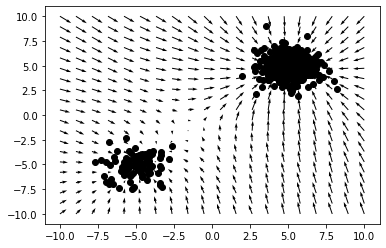

In [3]:
dataset = get_dataloader(args.dataset, False, args.batch_size).dataset
draw_vector_field(model, dataset, device)

## Techniques and Hyperparameters

The paper's main contribution is the theoratical analysis of the score based generative models. It provides several techniques to improve the performance by configuring the training of the NCSN model and sampling from the model. They gave further insight into how we should select the hyperparameters and made some theoretical analysis on them. Therefore, here, we discuss how these hyperparamters are calculated; although we have used readily calculated ones given in the paper in our experiments.

In [4]:
Args = namedtuple('Args', ['cuda',
                           'dataset',
                           'model',
                           'batch_size',
                           'epochs',
                           'lr',
                           'L',
                           'sigma1',
                           'eps',
                           'T',
                           'reduction'])
args = Args(
    cuda = True,
    dataset = 'CIFAR10',
    model = 'NCSNv2',
    batch_size = 128,
    epochs = 770,
    lr = 1e-4, # learning rate
    L = 232, # the number of noise scales
    sigma1 = 50, # the largest noise scale
    eps = 6.2e-6, # the scaling constant used in step-size calculation
    T = 5, # the number of iterations done at every noise scale in Annealed Langevin Dynamics
    reduction = 'mean'
)

Initial noise scale ($\sigma_1$) controls the diversity. However, choosing the initial noise scale too large will increase the required number of steps for Langevin dynamics. Let $\{x^{(1)}, x^{(2)}, \cdot\cdot\cdot , x^{(N)}\}$ be the dataset, which is i.i.d. sampled from $p_{data}(x)$, and $x^{(i)}$ is the $i^{th}$ sample.

**Proposition 1.** Let $\hat{p}_{\sigma_1} (\mathbf{x}) \triangleq \dfrac{1}{N} \sum^{N}_{i=1}p^{(i)}(\mathbf{x})$, where $p^{(i)}(\mathbf{x})\triangleq \mathcal{N} (\mathbf{x} | \mathbf{x}^{(i)}, \sigma^2_1 \mathbf{I})$. With $r^{(i)}(\mathbf{x})\triangleq \dfrac{p^{(i)}(\mathbf{x})}{\sum^{N}_{k=1}p^{(k)}(\mathbf{x})}
$ , the score function is $\nabla_\mathbf{x} \log \hat{p}_{\sigma_1}(\mathbf{x}) = \sum^{N}_{i=1} r^{(i)}(\mathbf{x})\nabla_\mathbf{x} \log p^{(i)}(\mathbf{x})$. Moreover,
<center>
$\mathbb{E}_{p^{(i)}(\mathbf{x})} [r^{(j)}(\mathbf{x}) ] \leq \dfrac{1}{2} \exp{\left(-\dfrac{\|\mathbf{x}^{(i)}-\mathbf{x}^{(j)}\|^2_2}{8\sigma^2_1}\right)}$
</center>

In order for Langevin dynamics to explore any component $p^{(i)}(\mathbf{x})$ when initialized from any other component $p^{(j)}(\mathbf{x})$ where $i\neq j$, the score function, $\nabla_\mathbf{x} \log \hat{p}_{\sigma_1}(\mathbf{x})$, should consider each component (on average). From the above proposition, if $\sigma_1$ is small compared to $\|\mathbf{x}^{(i)}-\mathbf{x}^{(j)}\|_2$, the expected value $\mathbb{E}_{p^{(i)}(\mathbf{x})} [r^{(j)}(\mathbf{x})]$ will decay exponentially fast and the score function will ignore $p^{(j)}(\mathbf{x})$ component when initialized $\mathbf{x}$ with $p^{(i)}(\mathbf{x})$. To avoid such cases, they introduce Technique 1.

**Technique 1** (Initial noise scale). *Choose $\sigma_1$ to be as large as the maximum Euclidean distance between all pairs of training data points.*

In [5]:
dataloader1 = get_dataloader('CIFAR10', True, 5000)
dataloader2 = get_dataloader('CIFAR10', True, 5000)

max_l2_dist = 0
for images1, _ in tqdm(dataloader1):
    images1 = images1.to(device)
    for images2, _ in dataloader2:
        images2 = images2.to(device)
        l2_dist = torch.cdist(images1.view(1, images1.size(0), -1), images2.view(1, images2.size(0), -1))
        current_max = torch.max(l2_dist).item()
        if current_max > max_l2_dist:
            max_l2_dist = current_max

print('Maximum L2 distance between CIFAR10 images:', max_l2_dist)

Files already downloaded and verified
Files already downloaded and verified


100%|███████████████████████████████████████████| 10/10 [06:32<00:00, 39.22s/it]

Maximum L2 distance between CIFAR10 images: 53.414974212646484


In Langevin dynamics, the noise scales are used in order from the highest to the lowest. When switching to a lower noise scale, the samples from the previous noise scale should be in the high density regions of the new, lower, noise scale. The decomposition of $p_{\sigma_i}(\mathbf{x})$ in hyperspherical coordinates is $p(\phi)p_{\sigma_i}(r)$, where $r$ and $\phi$ denote the radial and angular coordinates of x respectively. The angular coordinates are uniform. So, the $p_{\sigma_i}(r)$'s must overlap. 

**Proposition 2.** Let $\mathbf{x} \in \mathbb{R}^D \sim \mathcal{N}(0, \sigma^2 \mathbf{I})$, and $r = \|\mathbf{x}\|_2$. We have
$p(r) = \dfrac{1}{2^{D/2-1}\Gamma(D/2)} \dfrac{r^{D-1}}{\sigma^D}\exp
\left(-\dfrac{r^2}{2\sigma^2}
\right)$
and $r - \sqrt{D}\sigma 
\xrightarrow{d} \mathcal{N}(0, \sigma^2/2)$ when $D \rightarrow \infty$.

<img src="images/technique2.png" alt="technique2" width="500"/>

From three sigma rule,  $p_{\sigma_{i-1}}(r)$ has high density in $I_{i-1} \triangleq [\sqrt{D}\sigma_{i-1} - 3\sigma_{i-1}^2/2, \sqrt{D}\sigma_{i-1} + 3\sigma_{i-1}^2/2]$. In order to make sure that $p_{\sigma_i}(r)$ covers high density regions of $p_{\sigma_{i-1}}(r)$, they propose Technique 2, where $\gamma=\dfrac{\sigma_{i-1}}{\sigma_{i}}$ and $\Phi(\cdot)$ is the CDF of standard Gaussian. 

**Technique 2** (Other noise scales). *Choose $\{\sigma_i\}^L_{i=1}$ as a geometric progression with common ratio $\gamma$, such that*
<center>
$\Phi(\sqrt{2D}(\gamma - 1) + 3\gamma) - \Phi(\sqrt{2D}(\gamma - 1) - 3\gamma) \approx 0.5$.
</center>

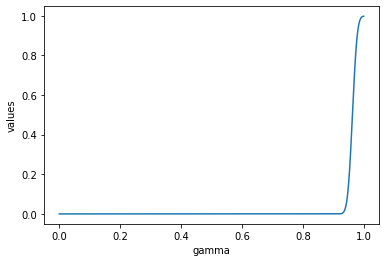

Calculated gamma: 0.9630963096309632
The value that can be inferred from [1]: 0.9638


In [6]:
# The dimension for a CIFAR10 image 
D = 32*32*3
gamma = np.linspace(0, 1, 10000)
values = norm.cdf(np.sqrt(2*D) * (gamma - 1) + 3 * gamma) - norm.cdf(np.sqrt(2*D) * (gamma - 1) - 3 * gamma)
plt.plot(gamma, values)
plt.xlabel('gamma')
plt.ylabel('values')
plt.show()

# Calculating the gamma that gives a value closest to 0.5
gamma = gamma[np.argmin((values-0.5)**2)]
print('Calculated gamma:', gamma)
print('The value that can be inferred from [1]:', 0.9638)

After calculating $\gamma$, we have obtained the number of noise scales, $L$. We are using the initial and final noise scale and $L$ to calculate the other noise scales for training and sampling.

In [7]:
# Calculating L from gamma, sigma1 and sigmaL
sigma1 = 50   # calculated 53 above. which is very close to 50, but we directly use the value given in paper.
sigmaL = 0.01 # Described as an appropriate value in [2].

L = 1
current_sigma = sigma1
while current_sigma > sigmaL:
    current_sigma *= gamma
    L += 1
print('Calculated L:', L)
print('The value given in [1]:', 232)

Calculated L: 228
The value given in [1]: 232


As it is noted in [1], the norm of the score functions are proportional to $1/\sigma_i$'s. Therefore, it is more efficient to use an unconditional network and scale the score function with $1/\sigma_i$. After this modification, the objective function becomes:

<center>
$\dfrac{1}{2L} \sum_{1}^{L} \mathbb{E}_{p_{data}(\mathbf{x})}\mathbb{E}_{p_{\sigma_i}(\mathbf{\tilde{x}}| \mathbf{x})}\left[ \left| \left| \mathbf{s_{\theta}}(\mathbf{\tilde{x}}) + \dfrac{\mathbf{\tilde{x}} - \mathbf{x}}{\sigma_i} \right| \right|_{2}^{2} \right]$.
</center>

**Technique 3**  (Noise conditioning). *Parameterize the NCSN with $s_\theta (x,\sigma) = s_\theta(x)/\sigma$, where $s_\theta (x)$
is an unconditional score network.*

While sampling from the model, each noise scale $\sigma_i$ is applied for $T$ steps and the initial sample, $\mathbf{x}_0$, is obtained with the previous noise scale $\sigma_{i-1}$. In $T$ many steps, the variance of sample $\mathbf{x}_T$ must approach to $\sigma_i$ with the following updates: $x_{t+1} \leftarrow x_t + \alpha\nabla_x \log p_{\sigma_i} (x_t) + \sqrt{2\alpha}z_t $, where $x_0\sim p_{\sigma_{i-1}(x)} $ and $z_t\sim \mathcal{N}(0,\mathbf{I})$.

The score function is applied for $T$ steps with step length $\alpha$. The step length is calculated by scaling the standard deviations with $\epsilon$. 

**Proposition 3.** Let $\gamma = \dfrac{\sigma_{i-1}}{\sigma_i}$. For $\alpha = \epsilon \cdot \dfrac{\sigma^2_i}{\sigma^2_L}$
(as in Algorithm 1), we have $\mathbf{x}_T \sim \mathcal{N}(\mathbf{0}, s^2_T \mathbf{I})$, where 
<center>
$\dfrac{s^2_T}{\sigma^2_i} = \left(1-\dfrac{\epsilon}{\sigma^2_L}\right)^{2T}\left(\gamma^2-\dfrac{2\epsilon}{\sigma^2_L-\sigma^2_L(1-\dfrac{\epsilon}{\sigma^2_L})^2}\right) + \dfrac{2\epsilon}{\sigma^2_L-\sigma^2_L(1-\dfrac{\epsilon}{\sigma^2_L})^2}$
</center>

In order for Langevin dynamics to connect adjacent noise scales, $\dfrac{s_T}{\sigma_i^2}$ ratio should be close to 1. With the above proposition, choosing compatible $\epsilon$ and $T$ values will satisfy the need. Since $T$ choice directly affects the computation time, finding $\epsilon$ with using a reasonable $T$ is more efficient. 

**Technique 4** (Selecting T and $\epsilon$). *Choose T as large as allowed by a computing budget and then select an $\epsilon$ that makes above equation maximally close to 1.*

In [8]:
# T is the number of iterations done at every noise scale in Annealed Langevin dynamics.
T = 5

eps = np.linspace(10**-8, 0.1, 1000000)
values = ((1- (eps/(sigmaL**2))) ** (2*T)) *\
        (gamma ** 2 - 2 * eps / (sigmaL ** 2 - (sigmaL ** 2) *((1 - eps/(sigmaL**2)) ** 2))) +\
        (2*eps / (sigmaL ** 2 - (sigmaL**2)*(1- eps/(sigmaL**2))**2))

print(values.shape)

# We want the eps that give the value closest to 1.
eps = eps[np.argmin((values-1)**2)]
print('Calculated eps:', eps)
print('The value given in [1]:', 6.2 * 10**-6)

(1000000,)
Calculated eps: 8.91000801000801e-06
The value given in [1]: 6.2e-06


With vanilla NCSN, samples from the same checkpoint have noticeable color shifts. Furthermore, the FID scores fluctuate significantly during training. To overcome this problem, Song and Ermon have proposed to use exponential moving average (EMA). They have used different set of parameters ($\theta'$), while sampling from the network. $\theta'$ is updated after each iteration by scaling the current network parameters with some momentum parameter, $m$.

$\theta' \leftarrow m \theta' + (1-m) \theta_i$, where $\theta_i$ is the parameters of the network after the $i_{th}$ training iteration.

**Technique 5** (EMA). *Apply exponential moving average to parameters when sampling.*

## Training and saving checkpoints

In [9]:
device = torch.device('cuda' if args.cuda else 'cpu')
name = get_name(args)
save_folder = os.path.join('model_saves', name)

# If the model is already trained, skip training.
if not os.path.exists(save_folder):
    train_loader = get_dataloader(args.dataset, True, args.batch_size)
    model = get_model(args.model).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    train(model, train_loader, optimizer, device, args)
model=None

## Loading the pretrained model, sampling and FID calculation

In [10]:
checkpoint_increment = 5000

samples_folder = os.path.join('samples_folder', name)

model = get_model(args.model).to(device)

test_loader = get_dataloader(args.dataset, False, args.batch_size)
noise_scales = calculate_noise_scales(args.sigma1, 0.01, args.L)

# Removing cached statistics of the real dataset
remove_cached_real_feature_mu_sigmas()

fid_list = []
lowest_iteration = -1
lowest_fid = float('inf')
for iteration in range(checkpoint_increment, 300001, checkpoint_increment):
    print('Calculating FID for checkpoint{:d}'.format(iteration))
    checkpoint_samples_path = os.path.join(samples_folder, '{:d}.npy'.format(iteration))
    if not os.path.exists(checkpoint_samples_path):
        # The path to the saved model.
        model_path = os.path.join(save_folder, 'checkpoint{}'.format(iteration))
        # The folder for saving the sampled images.
        checkpoint_samples_folder = os.path.join(samples_folder, '{:d}'.format(iteration))
        # Exponential Moving Average of the model is used for FID calculation.
        model.load_state_dict(torch.load(model_path, map_location=device)['model_ema'])
        samples = sample(model, 1000, noise_scales, args.eps, args.T, checkpoint_samples_folder, device)
    else:
        samples = np.load(checkpoint_samples_path)
    fid = test(test_loader, samples, device, args)
    print('Calculated FID for checkpoint{:d}:'.format(iteration), fid)
    fid_list.append([iteration, fid])
    if fid < lowest_fid:
        lowest_fid = fid
        lowest_iteration = iteration

Files already downloaded and verified
Calculating FID for checkpoint5000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.03it/s]


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 59.84it/s]


Extracting features...


  0%|                                                    | 0/79 [00:00<?, ?it/s]/home/lava/Desktop/learning/NCSNv2/utils.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images)
100%|███████████████████████████████████████████| 79/79 [01:16<00:00,  1.04it/s]


Calculated FID for checkpoint5000: 206.32781631703597
Calculating FID for checkpoint10000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.02it/s]


Calculated FID for checkpoint10000: 179.03304195545888
Calculating FID for checkpoint15000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.05it/s]


Calculated FID for checkpoint15000: 218.89732100409776
Calculating FID for checkpoint20000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.04it/s]


Calculated FID for checkpoint20000: 281.4919084299522
Calculating FID for checkpoint25000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.04it/s]


Calculated FID for checkpoint25000: 190.91182474655972
Calculating FID for checkpoint30000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.02it/s]


Calculated FID for checkpoint30000: 178.16366748482676
Calculating FID for checkpoint35000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.01it/s]


Calculated FID for checkpoint35000: 248.71374778284
Calculating FID for checkpoint40000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.00it/s]


Calculated FID for checkpoint40000: 296.41198995107857
Calculating FID for checkpoint45000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.04it/s]


Calculated FID for checkpoint45000: 304.2860179304628
Calculating FID for checkpoint50000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.04it/s]


Calculated FID for checkpoint50000: 222.42134084911416
Calculating FID for checkpoint55000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.00s/it]


Calculated FID for checkpoint55000: 174.44589390062342
Calculating FID for checkpoint60000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.01it/s]


Calculated FID for checkpoint60000: 181.13820845102083
Calculating FID for checkpoint65000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.05it/s]


Calculated FID for checkpoint65000: 181.37537143312937
Calculating FID for checkpoint70000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.01it/s]


Calculated FID for checkpoint70000: 187.50687187376104
Calculating FID for checkpoint75000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.05it/s]


Calculated FID for checkpoint75000: 180.35622467004714
Calculating FID for checkpoint80000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.01it/s]


Calculated FID for checkpoint80000: 173.79417059305572
Calculating FID for checkpoint85000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.04it/s]


Calculated FID for checkpoint85000: 162.67413386985885
Calculating FID for checkpoint90000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:08<00:00,  1.01s/it]


Calculated FID for checkpoint90000: 157.96066414468763
Calculating FID for checkpoint95000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.05it/s]


Calculated FID for checkpoint95000: 140.54755116984447
Calculating FID for checkpoint100000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.01it/s]


Calculated FID for checkpoint100000: 136.14837883780854
Calculating FID for checkpoint105000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.05it/s]


Calculated FID for checkpoint105000: 129.3905629018307
Calculating FID for checkpoint110000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.04it/s]


Calculated FID for checkpoint110000: 120.16921083245069
Calculating FID for checkpoint115000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.01it/s]


Calculated FID for checkpoint115000: 113.90343590750217
Calculating FID for checkpoint120000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.05it/s]


Calculated FID for checkpoint120000: 102.96709579958656
Calculating FID for checkpoint125000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.05it/s]


Calculated FID for checkpoint125000: 96.55173272834074
Calculating FID for checkpoint130000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.02it/s]


Calculated FID for checkpoint130000: 92.09185905795592
Calculating FID for checkpoint135000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.02it/s]


Calculated FID for checkpoint135000: 80.17768128890481
Calculating FID for checkpoint140000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.03it/s]


Calculated FID for checkpoint140000: 74.18060989467577
Calculating FID for checkpoint145000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.03it/s]


Calculated FID for checkpoint145000: 72.34895853499549
Calculating FID for checkpoint150000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.01it/s]


Calculated FID for checkpoint150000: 63.4801341782013
Calculating FID for checkpoint155000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.03it/s]


Calculated FID for checkpoint155000: 60.68459884337583
Calculating FID for checkpoint160000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.03it/s]


Calculated FID for checkpoint160000: 57.79088983115413
Calculating FID for checkpoint165000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.01it/s]


Calculated FID for checkpoint165000: 55.87652164615395
Calculating FID for checkpoint170000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.04it/s]


Calculated FID for checkpoint170000: 53.60773720708468
Calculating FID for checkpoint175000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.02it/s]


Calculated FID for checkpoint175000: 50.22198752679172
Calculating FID for checkpoint180000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.04it/s]


Calculated FID for checkpoint180000: 50.254516968647614
Calculating FID for checkpoint185000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.04it/s]


Calculated FID for checkpoint185000: 51.28647600378967
Calculating FID for checkpoint190000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.01it/s]


Calculated FID for checkpoint190000: 47.76849208769909
Calculating FID for checkpoint195000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.04it/s]


Calculated FID for checkpoint195000: 48.003874258471924
Calculating FID for checkpoint200000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.04it/s]


Calculated FID for checkpoint200000: 47.980993870199015
Calculating FID for checkpoint205000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.04it/s]


Calculated FID for checkpoint205000: 48.48531765376842
Calculating FID for checkpoint210000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.01it/s]


Calculated FID for checkpoint210000: 47.032254027510234
Calculating FID for checkpoint215000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.02it/s]


Calculated FID for checkpoint215000: 46.32093105768139
Calculating FID for checkpoint220000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.01it/s]


Calculated FID for checkpoint220000: 44.670450567640614
Calculating FID for checkpoint225000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.02it/s]


Calculated FID for checkpoint225000: 43.78116997491661
Calculating FID for checkpoint230000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.00it/s]


Calculated FID for checkpoint230000: 43.61007305453413
Calculating FID for checkpoint235000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.06it/s]


Calculated FID for checkpoint235000: 44.12825915426225
Calculating FID for checkpoint240000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.04it/s]


Calculated FID for checkpoint240000: 43.61136974211021
Calculating FID for checkpoint245000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.05it/s]


Calculated FID for checkpoint245000: 44.5750183963044
Calculating FID for checkpoint250000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.03it/s]


Calculated FID for checkpoint250000: 43.56579049218019
Calculating FID for checkpoint255000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.03it/s]


Calculated FID for checkpoint255000: 41.64517312488458
Calculating FID for checkpoint260000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.01it/s]


Calculated FID for checkpoint260000: 42.85247867685403
Calculating FID for checkpoint265000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.04it/s]


Calculated FID for checkpoint265000: 41.66769444980831
Calculating FID for checkpoint270000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.01it/s]


Calculated FID for checkpoint270000: 41.30698886129854
Calculating FID for checkpoint275000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.06it/s]


Calculated FID for checkpoint275000: 42.088882054387724
Calculating FID for checkpoint280000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.04it/s]


Calculated FID for checkpoint280000: 41.1477605757761
Calculating FID for checkpoint285000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.04it/s]


Calculated FID for checkpoint285000: 39.74931328333932
Calculating FID for checkpoint290000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.01it/s]


Calculated FID for checkpoint290000: 41.39597224562189
Calculating FID for checkpoint295000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.01it/s]


Calculated FID for checkpoint295000: 41.54672483710429
Calculating FID for checkpoint300000
Extracting features...


100%|█████████████████████████████████████████████| 8/8 [00:07<00:00,  1.05it/s]


Calculated FID for checkpoint300000: 40.670504740609246


## Quantitative results
In this section, we evaluate the performance of our model. The goal we are trying to achieve is the FID score of 10.87 reported in Table 1 for NCSNv2 model with denoising on unconditional CIFAR10 images. This table can be seen below.

<img src="images/goal_table.png" alt="Table1" width="250"/>


They report the FID scores every 5000 iterations and find the best model by choosing the model with lowest FID score. Afterwards, they sample 50000 images from that model and report the final FID. We also follow the same strategy.

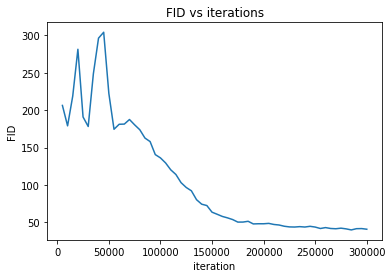

Best iteration: 285000.0
Best FID: 39.74931328333932


In [11]:
fids = np.array(fid_list)
plt.clf()
plt.plot(fids[:, 0], fids[:, 1])
plt.title('FID vs iterations')
plt.xlabel('iteration')
plt.ylabel('FID')
plt.show()

best_iteration_idx = np.argmin(fids[:, 1])
print('Best iteration:', fids[best_iteration_idx, 0])
print('Best FID:', np.min(fids[best_iteration_idx, 1]))

In [14]:
# Removing cached statistics of the real dataset
remove_cached_real_feature_mu_sigmas()

# Calculating the FID for the best checkpoint with 10000
best_iteration = int(fids[best_iteration_idx, 0])
checkpoint_samples_path = os.path.join(samples_folder, '{:d}_best.npy'.format(best_iteration))
if not os.path.exists(checkpoint_samples_path):
    # The path to the saved model.
    model_path = os.path.join(save_folder, 'checkpoint{}'.format(best_iteration))
    # The folder for saving the sampled images.
    checkpoint_samples_folder = os.path.join(samples_folder, '{:d}_best'.format(best_iteration))
    # Exponential Moving Average of the model is used for FID calculation.
    model.load_state_dict(torch.load(model_path, map_location=device)['model_ema'])
    samples = sample(model, 50000, noise_scales, args.eps, args.T, checkpoint_samples_folder, device)
else:
    samples = np.load(checkpoint_samples_path)
fid = test(test_loader, samples, device, args)
print('Calculated FID for the best checkpoint on Test Set:'.format(best_iteration), fid)

# Removing cached statistics of the real dataset
remove_cached_real_feature_mu_sigmas()

train_dataset = get_dataloader(args.dataset, True, args.batch_size).dataset
train_loader_for_test = torch.utils.data.DataLoader(train_dataset, args.batch_size, shuffle=False, pin_memory=True)
fid = test(train_loader_for_test, samples, device, args)
print('Calculated FID for the best checkpoint on Train Set:'.format(best_iteration), fid)

Extracting features...


100%|█████████████████████████████████████████| 391/391 [06:26<00:00,  1.01it/s]


100%|███████████████████████████████████████████| 79/79 [00:01<00:00, 44.54it/s]


Extracting features...


100%|███████████████████████████████████████████| 79/79 [01:19<00:00,  1.00s/it]


Calculated FID for the best checkpoint on Test Set: 14.53815976416283
Files already downloaded and verified
Extracting features...


100%|█████████████████████████████████████████| 391/391 [06:32<00:00,  1.00s/it]


100%|█████████████████████████████████████████| 391/391 [00:11<00:00, 34.53it/s]


Extracting features...


100%|█████████████████████████████████████████| 391/391 [06:29<00:00,  1.00it/s]


Calculated FID for the best checkpoint on Train Set: 12.532067386563009


We obtain the FID results that can be seen in the table below.

|  Results     |         FID               |
|:------------ |:-------------------------:|
| NCSNv2 [1]   |        10.87              |
| NCSNv2 (Ours)|14.54 (Test), 12.53 (Train)|

Although we were able to obtain very close results, the difference may stem from:
* While implementing the InstanceNorm++, we did not track the running statistics as we did not see it in the paper. However, it can also be the case that they use it in the original implementation.
* The paper states that they apply Exponential Moving Average after every iteration. However, we missed that information while reading the paper and only applied it every 5000 iteration.
* While building the architecture, we used RefineNet [3] as our example and mimicked its architectural choices. However, our final model did not 100% matched with the model diagrams in the NCSNv2 paper [1]. However, as we could not find further information on the model in the paper, we continued with the architecture we used in version 1.

### Sanity check of quantitative results with a readily available FID module
We observed a discrepancy when we calculated FID using 1k samples and 50k samples. To check whether the calculated FID scores are correct, we also calculated the FID using another, readily available implementation. We use the module implemented by Maximilian Seitzer [7]. The results calculated using test set can be seen in the table below. As can be seen, a similar increase is also observed with another implementation as well.

| FID         | 1K Samples | 50K Samples |
|-------------|------------|-------------|
| Ours        | 39.75      | 14.54       |
| Seitzer [7] | 43.39      | 16.03       |

Additionally, to test whether the samples in a batch correlate or not (It shouldn't in this architecture.), we sampled random 1K examples from the previously sampled 50k examples. The increase in FID score could also be observed in this situation. Therefore, the FID calculation seems correct and the change in FID is not caused by a correlation in a batch.

## Qualitative results

We present the samples generated with the best model. A cut from Figure 25 in the paper [1] can be seen below.

<img src="images/fig25.jpg" alt="A cut from Figure 25" width="500"/>

We also show our samples below which are not cherry-picked. The sample quality is comparable to the ones in Figure 25 in [1].

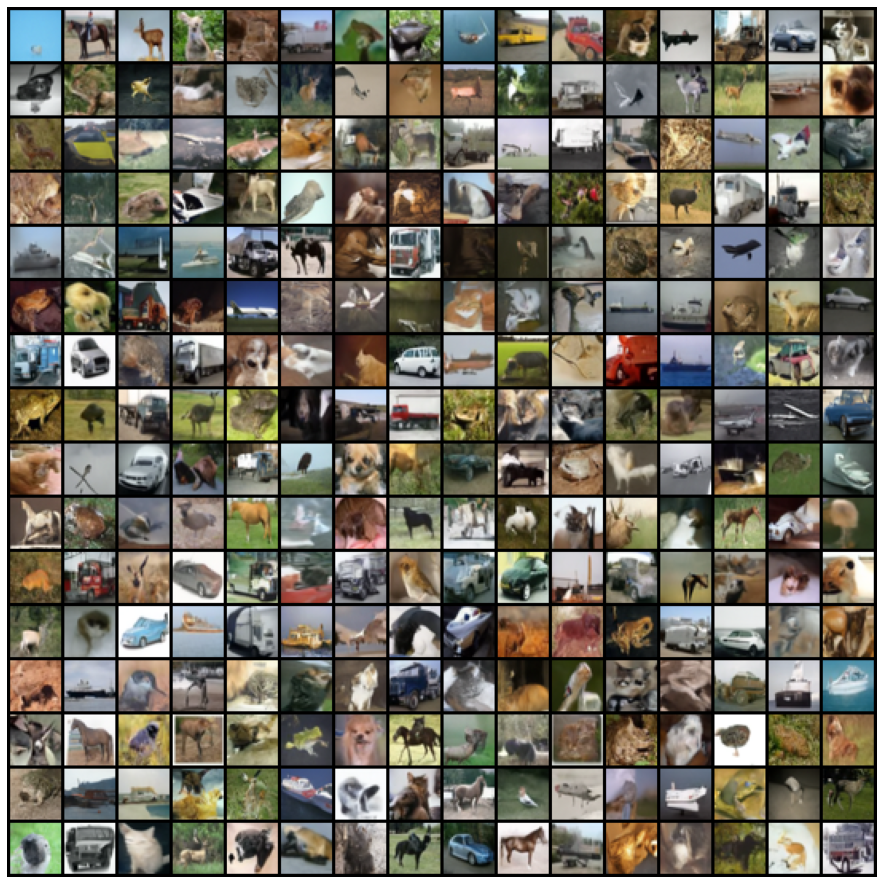

In [18]:
plt.clf()
best_fid_samples_path = os.path.join(samples_folder, '{:d}.npy'.format(lowest_iteration))
samples = np.load(best_fid_samples_path)
samples = torch.from_numpy(samples)
grid_width = 16
grid_height = 16
image_grid = torchvision.utils.make_grid(samples[:grid_width*grid_height], nrow=grid_width)
plt.rcParams['figure.figsize'] = [grid_height, grid_width]
plt.imshow(image_grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

## Challenges

- For us, the most time consuming and somewhat unclear part of the paper was the architectural details. We had to refer several papers and use our intuition to combine them to build our final model.

- In [2], they use RefineNet [3] architecture. However, they replaced the subsampling layers with dilated convolutions and the details of the dilated convolutions are left unclear. While implementing, we assumed that the size of the output layer is preserved. Due to using dilated convolutions, the size of the receptive field is increased without using strides.

- In Appendix B.1 in [1], the size of the 3rd RefineBlock is reported to be 128. However, after examining the RefineNet architecture proposed in [3], we saw that the channel size of a RefineBlock should be determined according to the outputs of the corresponding ResNet blocks and in our model we had to use channel size of 256.

- While sampling from the model, the paper uses Annealed Langevin Dynamics and all the steps are detailed. However, the initialization of the first noise sample (x_0) is not mentioned. So, we randomly initialized x_0 with a uniform distribution from the [0,1) interval.

- The loss function is the squared error between the estimated score and the real score. We have tried both the sum of squared errors and the mean squared error. We have obtained better results with the mean squared error. The results presented in this report are from the mean reduction one.

- While calculating the Frechet Inception Distance, we used Schur Decomposition to calculate the square root of the covariance matrices as we could not find which operation is used in [4]. The operation could not be an element-wise square root as there can be negative elements. We also tried to use Cholesky decomposition, which gives lower/upper triangular results, but it gave exceptions during calculation. Therefore, we are not really sure if we calculated FID correctly. To do a sanity check in version 2, we compared our FID results with a different implemention.

- In version 1, we misunderstood that they did a pretraining on ResNet part before the score estimation training. However, this was not the case.

## Acknowledgements

We would like to thank our instructor Gökberk Cinbiş for their suggestions in FID calculation sanity check.

We also would like to thank our reviewers Alpay Özkan and Hıdır Yeşiltepe for their valuable comments.
